<a href="https://colab.research.google.com/github/npraneeth09/CryptoTradingBot/blob/main/Trading_Algo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load data from CSV file
df = pd.read_csv('/content/btc_1h.csv')
df.rename(columns={'Date': 'timestamp', 'Open': 'open', 'Close': 'close', 'High': 'high', 'Volume': 'volume', 'Low': 'low'},
          inplace=True)

# Assuming the 'timestamp' column is in datetime format, otherwise, convert it
df['timestamp'] = pd.to_datetime(df['timestamp'])

#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA


#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)


#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# Function to create technical indicators
def create_technical_indicators(dataset):
    dataset['MOM10'] = MOM(dataset['close'], 10)
    dataset['MOM30'] = MOM(dataset['close'], 30)
    dataset['ROC10'] = ROC(dataset['close'], 10)
    dataset['ROC30'] = ROC(dataset['close'], 30)
    dataset['EMA10'] = EMA(dataset, 10)
    dataset['EMA30'] = EMA(dataset, 30)
    dataset['EMA200'] = EMA(dataset, 200)
    dataset['RSI10'] = RSI(dataset['close'], 10)
    dataset['RSI30'] = RSI(dataset['close'], 30)
    dataset['RSI200'] = RSI(dataset['close'], 200)
    dataset['%K10'] = STOK(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%D10'] = STOD(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%K30'] = STOK(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%D30'] = STOD(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%K200'] = STOK(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['%D200'] = STOD(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['MA21'] = MA(dataset, 10)
    dataset['MA63'] = MA(dataset, 30)
    dataset['MA252'] = MA(dataset, 200)
    return dataset

# Function to create target variable
def create_target_variable(df, look_forward_period=1):
    df['target'] = df['close'].shift(-look_forward_period) >= df['close']
    df['target'] = df['target'].astype(int)

# Function to build and evaluate Extra Trees Classifier model
def build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid):
    etc_model = ExtraTreesClassifier(random_state=42)

    # Grid Search
    grid = GridSearchCV(estimator=etc_model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_result = grid.fit(X_train, y_train)

    # Print Results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    ranks = grid_result.cv_results_['rank_test_score']
    for mean, stdev, param, rank in zip(means, stds, params, ranks):
        print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

    best_params = grid_result.best_params_
    etc_model.set_params(**best_params)
    etc_model.fit(X_train, y_train)

    predictions = etc_model.predict(X_test)

    print("\nFinal Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

    return etc_model

 # Function to implement a complete trading strategy
def implement_trading_strategy(model, X, historical_data):
    signals = model.predict(X)

    # Initialize variables for tracking trades
    position = 0  # 1 for long (buy), -1 for short (sell), 0 for no position
    wallet = 10000  # Initial capital in USDT
    position_size = 1 # Fraction of capital to allocate per trade
    stop_loss_percent = 0.02  # Stop loss percentage
    take_profit_percent = 0.3  # Take profit percentage

    # DataFrame to store trade history
    trade_history = pd.DataFrame(columns=['timestamp', 'action', 'price', 'quantity', 'capital'])

    for i in range(len(signals)):
        if signals[i] == 1 and position == 0:  # Buy signal and no current position
            entry_price = historical_data['close'].iloc[i]
            position_size = wallet * position_size / entry_price
            wallet -= wallet * position_size
            position = 1  # Set position to long
            trade_history = trade_history.append({'timestamp': historical_data.index[i],
                                                  'signal': '1',
                                                  'price': entry_price,
                                                  'quantity': position_size,
                                                  'capital': wallet + position_size * entry_price,
                                                  'open':historical_data['open'].iloc[i],
                                                  'close': historical_data['close'].iloc[i],
                                                  'high' : historical_data['high'].iloc[i],
                                                  'low' : historical_data['low'].iloc[i]},
                                                 ignore_index=True)
        elif signals[i] == -1 and position == 0:  # Sell signal and no current position
            entry_price = historical_data['close'].iloc[i]
            position_size = wallet * position_size / entry_price
            wallet += wallet * position_size
            position = -1  # Set position to short
            trade_history = trade_history.append({'timestamp': historical_data.index[i],
                                                  'signal': '-1',
                                                  'price': entry_price,
                                                  'quantity': position_size,
                                                  'capital': wallet - position_size * entry_price,
                                                  'open':historical_data['open'].iloc[i],
                                                  'close': historical_data['close'].iloc[i],
                                                  'high' : historical_data['high'].iloc[i],
                                                  'low' : historical_data['low'].iloc[i]},
                                                 ignore_index=True)
        elif signals[i] == 0 and position != 0:  # Hold signal and there is an open position
            if position == 1:  # Check for stop loss or take profit conditions for long position
                current_price = historical_data['close'].iloc[i]
                if current_price <= entry_price * (1 - stop_loss_percent) or current_price >= entry_price * (
                        1 + take_profit_percent):
                    wallet += position_size * current_price
                    position = 0
                    trade_history = trade_history.append({'timestamp': historical_data.index[i],
                                                          'signal': '-1',
                                                          'price': current_price,
                                                          'quantity': position_size,
                                                          'capital': wallet,
                                                  'open':historical_data['open'].iloc[i],
                                                  'close': historical_data['close'].iloc[i],
                                                  'high' : historical_data['high'].iloc[i],
                                                  'low' : historical_data['low'].iloc[i]},
                                                         ignore_index=True)
            elif position == -1:  # Check for stop loss or take profit conditions for short position
                current_price = historical_data['close'].iloc[i]
                if current_price >= entry_price * (1 - stop_loss_percent) or current_price <= entry_price * (
                        1 + take_profit_percent):
                    wallet -= position_size * current_price
                    position = 0
                    trade_history = trade_history.append({'timestamp': historical_data.index[i],
                                                          'signal': '1',
                                                          'price': current_price,
                                                          'quantity': position_size,
                                                          'capital': wallet,
                                                  'open':historical_data['open'].iloc[i],
                                                  'close': historical_data['close'].iloc[i],
                                                  'high' : historical_data['high'].iloc[i],
                                                  'low' : historical_data['low'].iloc[i]},
                                                         ignore_index=True)
        else:
           current_price = historical_data['close'].iloc[i]
           trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                          'signal': '0',
                                                          'price': current_price,
                                                          'quantity': position_size,
                                                          'capital': wallet+position_size*current_price,
                                                  'open':historical_data['open'].iloc[i],
                                                  'close': historical_data['close'].iloc[i],
                                                  'high' : historical_data['high'].iloc[i],
                                                  'low' : historical_data['low'].iloc[i]},
                                                         ignore_index=True)
    # Close any remaining open position at the end
    if position != 0:
        current_price = historical_data['close'].iloc[-1]
        wallet += position_size * current_price
        trade_history = trade_history.append({'timestamp': historical_data.index[-1],
                                              'action': 'Sell' if position == 1 else 'Buy',
                                              'price': current_price,
                                              'quantity': position_size,
                                              'capital': wallet,
                                                  'open':historical_data['open'].iloc[-1],
                                                  'close': historical_data['close'].iloc[-1],
                                                  'high' : historical_data['high'].iloc[-1],
                                                  'low' : historical_data['low'].iloc[-1]},
                                             ignore_index=True)

    return trade_history
# Create technical indicators
df = create_technical_indicators(df)

# Create target variable
create_target_variable(df)

# Drop rows with NaN values resulting from creating technical indicators
df = df.dropna()

# Features and target variable
X_train = df.iloc[:int(0.7 * len(df))].drop(['timestamp', 'target'], axis=1)  # First 70% for training
y_train = df.iloc[:int(0.7 * len(df))]['target']

X_test = df.iloc[int(0.7 * len(df)):].drop(['timestamp', 'target'], axis=1)  # Remaining 30% for testing
y_test = df.iloc[int(0.7 * len(df)):]['target']

df_test = df.iloc[int(0.7* len(df)):]

# Fine-tune parameters with Grid Search
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'criterion': ['gini', 'entropy']
}

# Build and evaluate the model
model = build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid)

# Implement trading strategy
trade_history = implement_trading_strategy(model, X_test, df_test)

# Print trade history
print("\nTrade History:")
print(trade_history)

# # Save trade history to CSV
# trade_history.to_csv('/content/drive/MyDrive/trade_history.csv', index=False)

Best: 0.529891 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
#1 0.529891 (0.011299) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
#2 0.529649 (0.010671) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}

Final Model Evaluation:
Accuracy: 0.5227934956292885
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.24      0.33      5234
           1       0.52      0.79      0.63      5405

    accuracy                           0.52     10639
   macro avg       0.53      0.52      0.48     10639
weighted avg       0.53      0.52      0.48     10639

Confusion Matrix:
 [[1275 3959]
 [1118 4287]]

Trade History:
                timestamp action     price  quantity       capital signal  \
0                   25025    NaN  16291.86  0.613803  13861.965423      1   
1     2020-11-13 10:30:00    NaN  16233.88  0.613803  13826.377099      0   
2     2020-11-13 11:30:00    NaN  16314.54 

# **FINAL CODE**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


class TechnicalIndicators:
    # Exponential Moving Average
    @staticmethod
    def ema(df, column, n):
        return pd.Series(df[column].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')

    # Rate of Change
    @staticmethod
    def roc(df, column, n):
        m = df[column].diff(n - 1)
        n = df[column].shift(n - 1)
        return pd.Series(((m / n) * 100), name=f'ROC_{n}')

    # Momentum
    @staticmethod
    def mom(df, column, n):
        return pd.Series(df[column].diff(n), name=f'Momentum_{n}')

    # Relative Strength Index
    @staticmethod
    def rsi(series, period):
        delta = series.diff().dropna()
        u = delta * 0
        d = u.copy()
        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]
        u[u.index[period - 1]] = np.mean(u[:period])
        u = u.drop(u.index[:(period - 1)])
        d[d.index[period - 1]] = np.mean(d[:period])
        d = d.drop(d.index[:(period - 1)])
        rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period - 1, adjust=False).mean()
        return 100 - 100 / (1 + rs)

    # Stochastic Oscillator %K
    @staticmethod
    def stok(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        return stok

    # Stochastic Oscillator %D
    @staticmethod
    def stod(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        stod = stok.rolling(3).mean()
        return stod

    # Moving Average
    @staticmethod
    def ma(df, n):
        ma = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name=f'ma_{n}')
        return ma


class TradingStrategy:
    @staticmethod
    def implement(model, X, historical_data):
        signals = model.predict(X)

        position = 0
        wallet = 10000
        position_size = 0.5
        stop_loss_percent = 0.02
        take_profit_percent = 0.3
        trade_history = pd.DataFrame(columns=['timestamp', 'signal', 'price', 'quantity', 'capital', 'open', 'close',
                                              'high', 'low'])

        for i in range(len(signals)):
            if signals[i] == 1 and position == 0:  # Buy signal and no current position
                entry_price = historical_data['close'].iloc[i]
                position_size = wallet * position_size / entry_price
                wallet -= wallet * position_size
                position = 1
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '1',
                                                      'price': entry_price,
                                                      'quantity': position_size,
                                                      'capital': wallet + position_size * entry_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)
            elif signals[i] == -1 and position == 0:  # Sell signal and no current position
                entry_price = historical_data['close'].iloc[i]
                position_size = wallet * position_size / entry_price
                wallet += wallet * position_size
                position = -1
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '-1',
                                                      'price': entry_price,
                                                      'quantity': position_size,
                                                      'capital': wallet - position_size * entry_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)
            elif signals[i] == 0 and position != 0:  # Hold signal and there is an open position
                if position == 1:  # Check for stop loss or take profit conditions for long position
                    current_price = historical_data['close'].iloc[i]
                    if current_price <= entry_price * (1 - stop_loss_percent) or current_price >= entry_price * (
                            1 + take_profit_percent):
                        wallet += position_size * current_price
                        position = 0
                        trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '-1',
                                                              'price': current_price,
                                                              'quantity': position_size,
                                                              'capital': wallet,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)
                elif position == -1:  # Check for stop loss or take profit conditions for short position
                    current_price = historical_data['close'].iloc[i]
                    if current_price >= entry_price * (1 - stop_loss_percent) or current_price <= entry_price * (
                            1 + take_profit_percent):
                        wallet -= position_size * current_price
                        position = 0
                        trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '1',
                                                              'price': current_price,
                                                              'quantity': position_size,
                                                              'capital': wallet,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)
            else:
                current_price = historical_data['close'].iloc[i]
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '0',
                                                      'price': current_price,
                                                      'quantity': position_size,
                                                      'capital': wallet + position_size * current_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)

        # Close any remaining open position at the end
        if position != 0:
            current_price = historical_data['close'].iloc[-1]
            wallet += position_size * current_price
            trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[-1],
                                                  'signal': '-1' if position == 1 else '1',
                                                  'price': current_price,
                                                  'quantity': position_size,
                                                  'capital': wallet,
                                                  'open': historical_data['open'].iloc[-1],
                                                  'close': historical_data['close'].iloc[-1],
                                                  'high': historical_data['high'].iloc[-1],
                                                  'low': historical_data['low'].iloc[-1]},
                                                 ignore_index=True)

        return trade_history


def create_technical_indicators(dataset):
    tech_indicators = TechnicalIndicators()

    dataset['MOM10'] = tech_indicators.mom(dataset, 'close', 10)
    dataset['MOM30'] = tech_indicators.mom(dataset, 'close', 30)
    dataset['ROC10'] = tech_indicators.roc(dataset, 'close', 10)
    dataset['ROC30'] = tech_indicators.roc(dataset, 'close', 30)
    dataset['EMA10'] = tech_indicators.ema(dataset, 'close', 10)
    dataset['EMA30'] = tech_indicators.ema(dataset, 'close', 30)
    dataset['EMA200'] = tech_indicators.ema(dataset, 'close', 200)
    dataset['RSI10'] = tech_indicators.rsi(dataset['close'], 10)
    dataset['RSI30'] = tech_indicators.rsi(dataset['close'], 30)
    dataset['RSI200'] = tech_indicators.rsi(dataset['close'], 200)
    dataset['%K10'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%D10'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%K30'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%D30'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%K200'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['%D200'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['MA21'] = tech_indicators.ma(dataset, 10)
    dataset['MA63'] = tech_indicators.ma(dataset, 30)
    dataset['MA252'] = tech_indicators.ma(dataset, 200)

    return dataset


def create_target_variable(df, look_forward_period=1):
    df['target'] = df['close'].shift(-look_forward_period) >= df['close']
    df['target'] = df['target'].astype(int)


def build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid):
    etc_model = ExtraTreesClassifier(random_state=42)

    grid = GridSearchCV(estimator=etc_model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_result = grid.fit(X_train, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    ranks = grid_result.cv_results_['rank_test_score']
    for mean, stdev, param, rank in zip(means, stds, params, ranks):
        print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

    best_params = grid_result.best_params_
    etc_model.set_params(**best_params)
    etc_model.fit(X_train, y_train)

    predictions = etc_model.predict(X_test)

    print("\nFinal Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

    return etc_model


# Load data from CSV file
df = pd.read_csv('/content/btc_1h.csv')
df.rename(columns={'Date': 'timestamp', 'Open': 'open', 'Close': 'close', 'High': 'high', 'Volume': 'volume',
                   'Low': 'low'}, inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create technical indicators
df = create_technical_indicators(df)

# Create target variable
create_target_variable(df)

# Drop rows with NaN values resulting from creating technical indicators
df = df.dropna()

# Features and target variable
X_train = df.iloc[:int(0.7 * len(df))].drop(['timestamp', 'target'], axis=1)
y_train = df.iloc[:int(0.7 * len(df))]['target']

X_test = df.iloc[int(0.7 * len(df)):].drop(['timestamp', 'target'], axis=1)
y_test = df.iloc[int(0.7 * len(df)):]['target']

df_test = df.iloc[int(0.7 * len(df)):]

# Fine-tune parameters with Grid Search
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'criterion': ['gini', 'entropy']
}

# Build and evaluate the model
model = build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid)

# Implement trading strategy
trade_history = TradingStrategy.implement(model, X_test, df_test)

# Print trade history
print("\nTrade History:")
print(trade_history)

# Save trade history to CSV
trade_history.to_csv('/content/trade_history.csv', index=False)


total_closed_trades = len(trade_history[trade_history['signal'] == '-1'])

winning_trades = trade_history[trade_history['signal'] == '1']
losing_trades = trade_history[trade_history['signal'] == '-1']
net_1 = winning_trades['capital']
net_2 = losing_trades['capital']
net_trade_value = []
mtr = 0
mmtr = 1000000000
max_drawdown1=0
for i in range(len(net_1)):
    j = net_2.iloc[i] - net_1.iloc[i]
    net_trade_value.append(j)
    if j<0 :
      if max_drawdown1 > j:
          mtr = net_1.iloc[i]
          mmtr = net_2.iloc[i]
          max_drawdown1 = j




gross_profit1=[]
gross_loss1=[]
# max_drawdown1=0
count=0
for val in net_trade_value:
  if val > 0:
    gross_profit1.append(val)
    count+=1
  else:
    gross_loss1.append(val)
    # max_drawdown1=min(max_drawdown1,val)

gross_profit_val = np.sum(gross_profit1)
gross_loss_val = np.sum(gross_loss1)


gross_profit = gross_profit_val
gross_loss = gross_loss_val
net_profit = gross_profit + gross_loss
max_drawdown = max_drawdown1
total_closed_trades = len(losing_trades)
win_rate = ( count / total_closed_trades) * 100
max_drowdown_percentage= (mtr-mmtr)/mtr *100
average_annual_returns = ((net_profit)/10000)*100

print("Requested Metrics for Model:")
print("1. Gross Profit: ${:,.2f}".format(gross_profit))
print("2. Net Profit: ${:,.2f}".format(net_profit))
print("3. Total Closed Trades: {}".format(total_closed_trades))
print("4. Win Rate (Profitability %): {:.2f}%".format(win_rate))
print("5. Max Drawdown: ${:,.2f}".format(max_drawdown))
print("6. Gross Loss: ${:,.2f}".format(gross_loss))
print("7. Max Drawdown Percentage: {:,.2f}".format(max_drowdown_percentage))
print("8. Average Annual Returns: {:,.2f}".format(average_annual_returns))

Best: 0.529891 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
#1 0.529891 (0.011299) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
#2 0.529649 (0.010671) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}

Final Model Evaluation:
Accuracy: 0.5227934956292885
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.24      0.33      5234
           1       0.52      0.79      0.63      5405

    accuracy                           0.52     10639
   macro avg       0.53      0.52      0.48     10639
weighted avg       0.53      0.52      0.48     10639

Confusion Matrix:
 [[1275 3959]
 [1118 4287]]

Trade History:
               timestamp signal     price      quantity       capital  \
0    2020-11-13 04:30:00      1  16291.86  3.069017e-01  11930.982712   
1    2020-11-13 10:30:00      0  16233.88  3.069017e-01  11913.188549   
2    2020-11-13 11:30:00      0  16314.54  3.069017e-01

In [ ]:
print((net_profit+10000)/100)

233.89418473410362


In [ ]:
def calculate_sharpe_ratio(trade_history):
    # Calculate daily returns
    trade_history['daily_return'] = trade_history['capital'].pct_change()

    # Handle missing values
    trade_history['daily_return'].fillna(0, inplace=True)

    # Calculate average daily return (Rp)
    average_daily_return = trade_history['daily_return'].mean()

    # Assume a risk-free rate (Rf)
    risk_free_rate = 0.02/24  # You can adjust this based on your requirements

    # Calculate standard deviation of daily returns (σp)
    std_dev_daily_return = trade_history['daily_return'].std()

    # Calculate Sharpe Ratio
    sharpe_ratio = (average_daily_return - risk_free_rate) / std_dev_daily_return

    return sharpe_ratio


sharpe_ratio = calculate_sharpe_ratio(trade_history)
print("\nSharpe Ratio: {:.2f}".format(sharpe_ratio))


Sharpe Ratio: -0.04


In [ ]:
 trade_history['capital']

0       13861.965423
1       13826.377099
2       13875.886486
3       13838.297162
4       13844.692994
            ...     
8347    43035.177663
8348    43037.701251
8349    43041.967084
8350    42995.190483
8351    42995.190483
Name: capital, Length: 8352, dtype: float64

In [ ]:
 trade_history['daily_return'] .mean()

0       0.000000
1      -0.002567
2       0.003581
3      -0.002709
4       0.000462
          ...   
8347    0.000046
8348    0.000059
8349    0.000099
8350   -0.001087
8351    0.000000
Name: daily_return, Length: 8352, dtype: float64

Best Parameters:
Position Size: 1.0
Stop Loss Percent: 0.03
Take Profit Percent: 0.3
Best Net Profit: $9,619.23


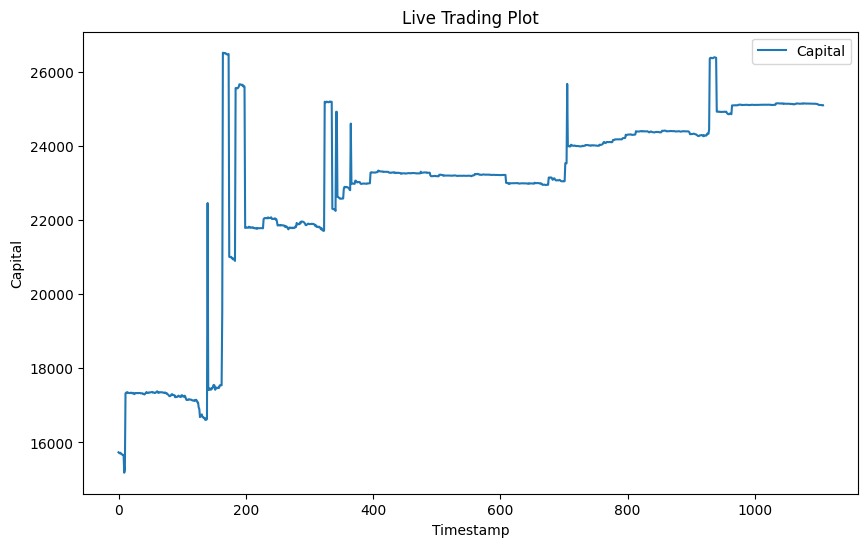

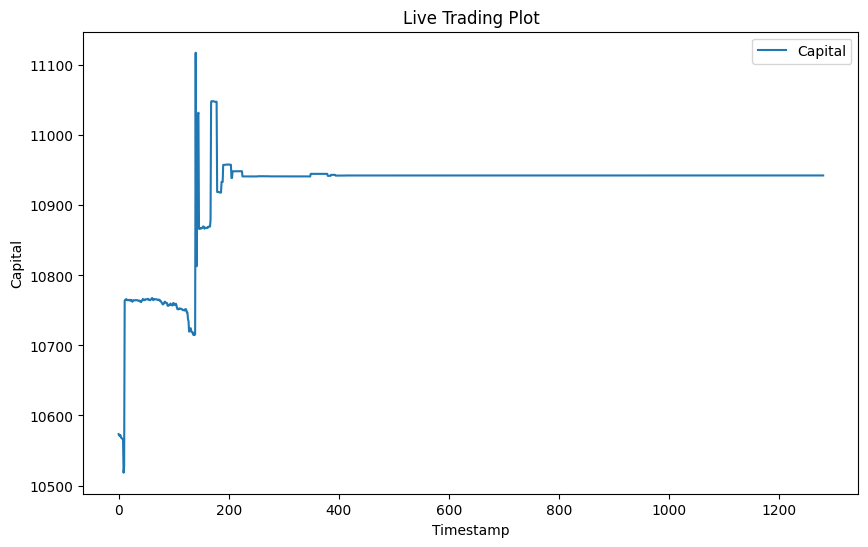

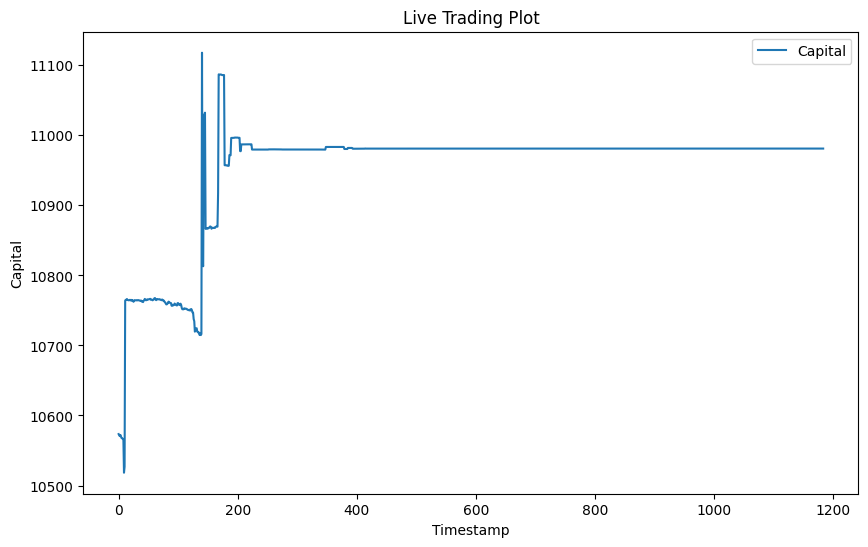

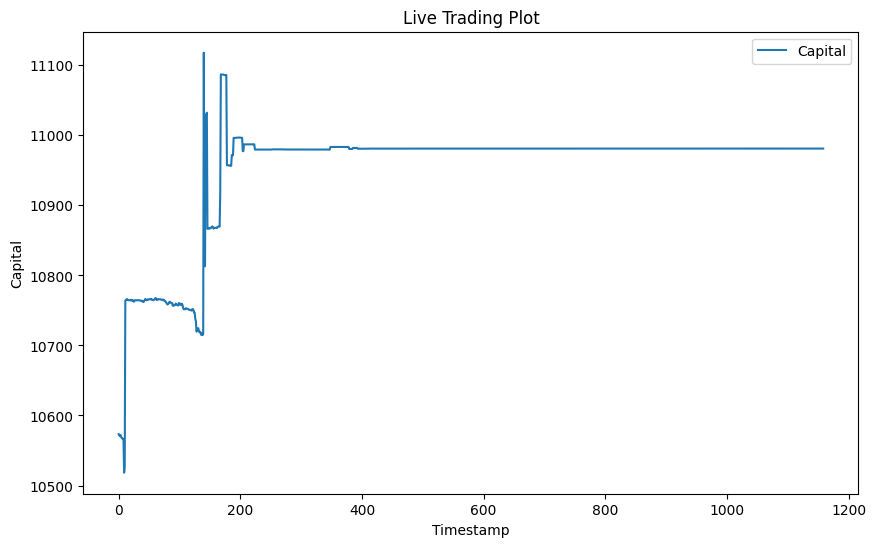

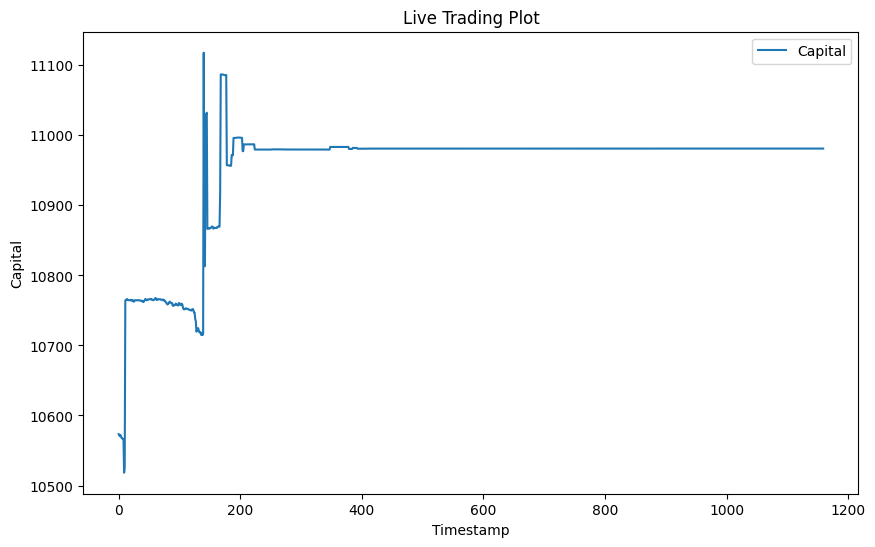

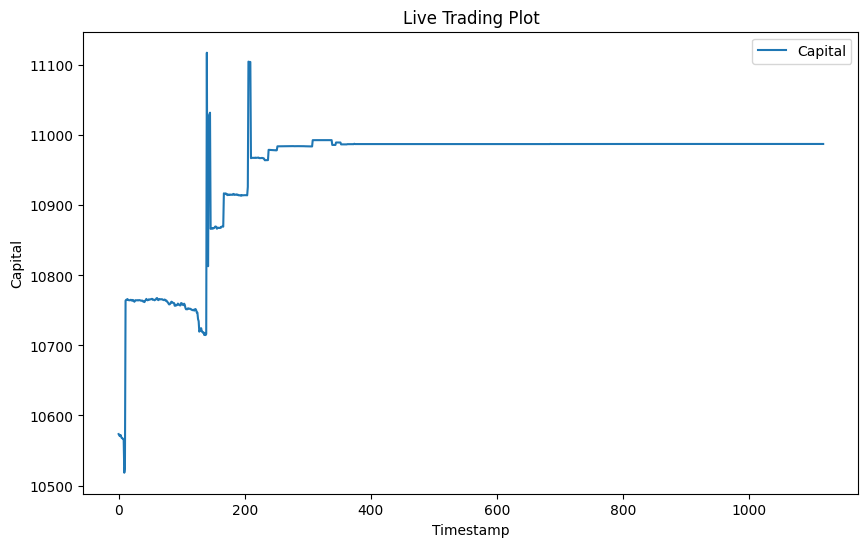

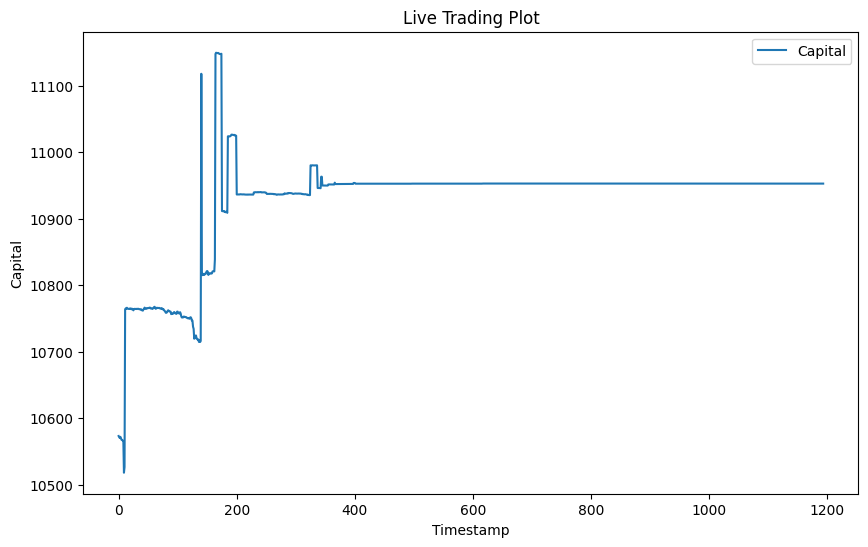

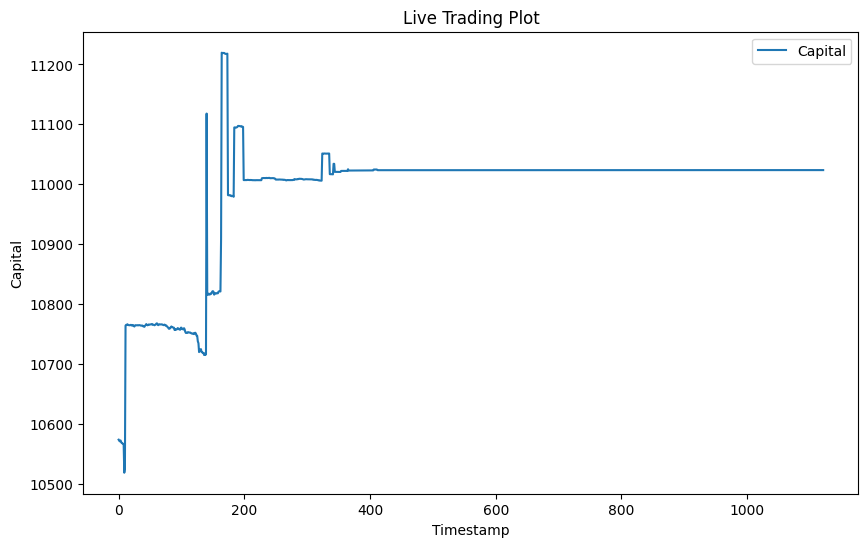

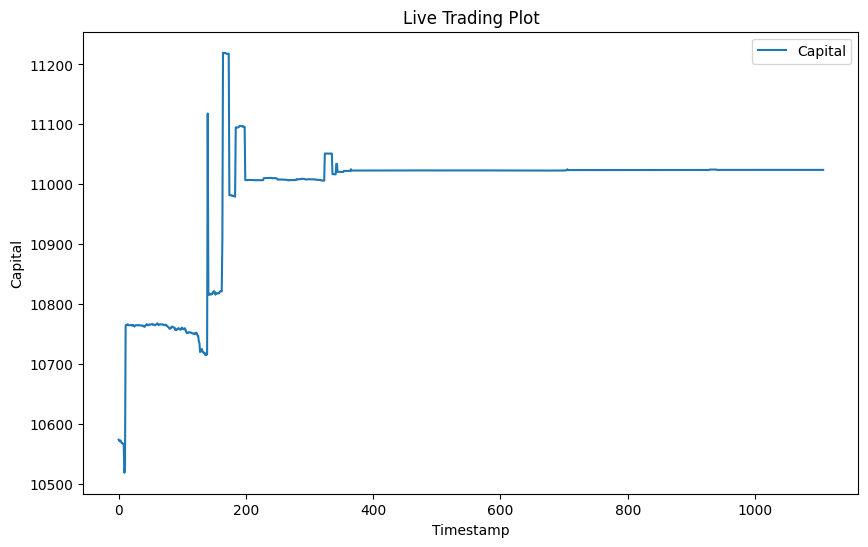

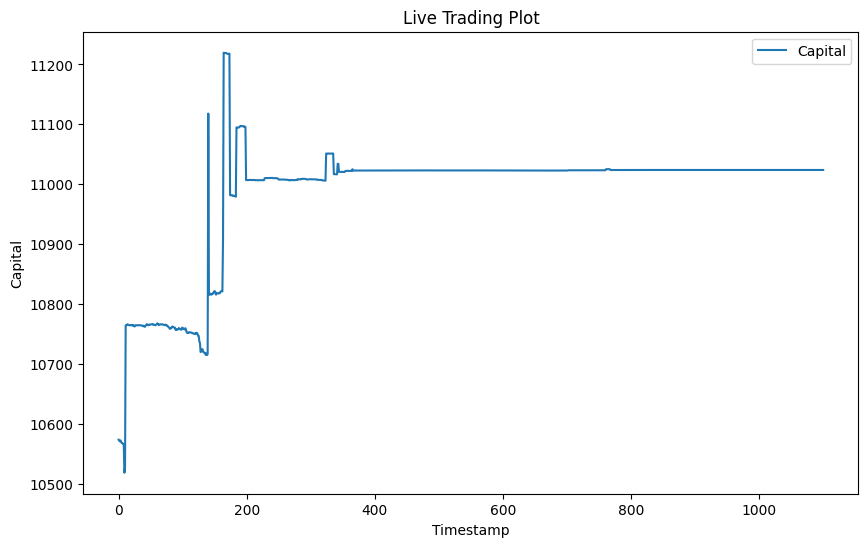

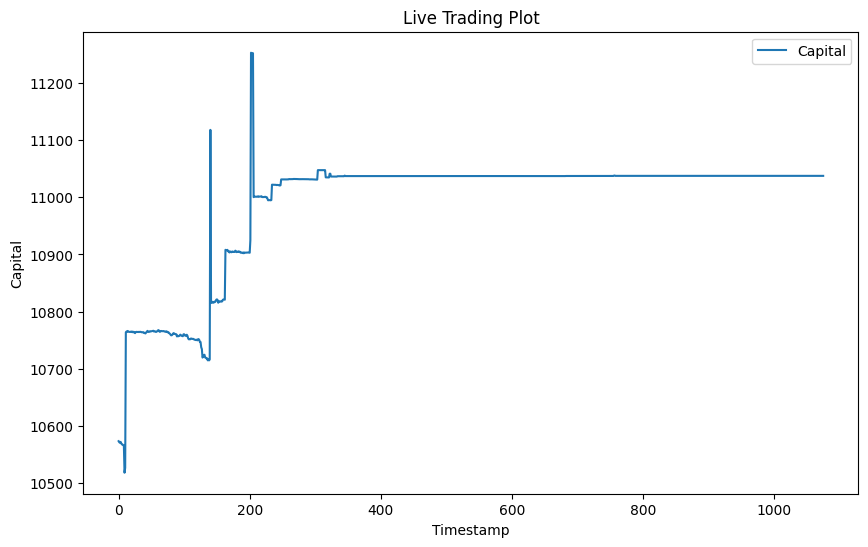

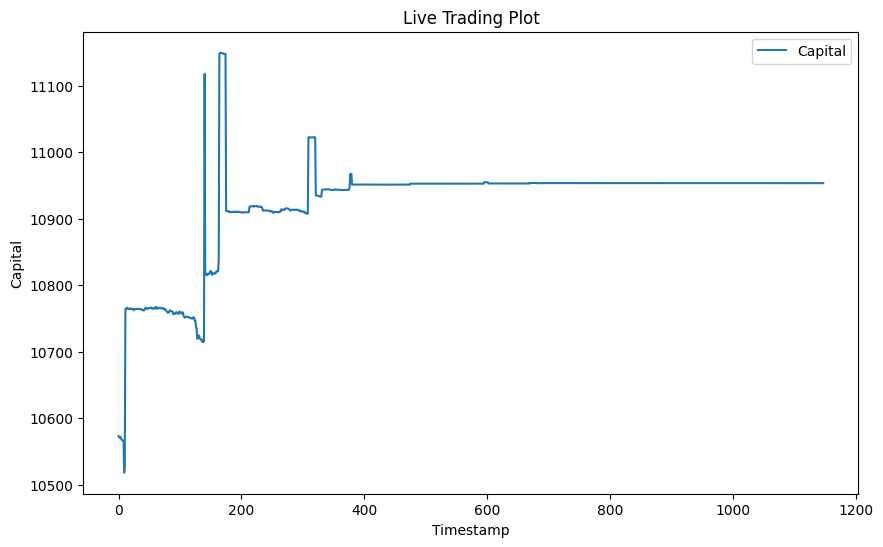

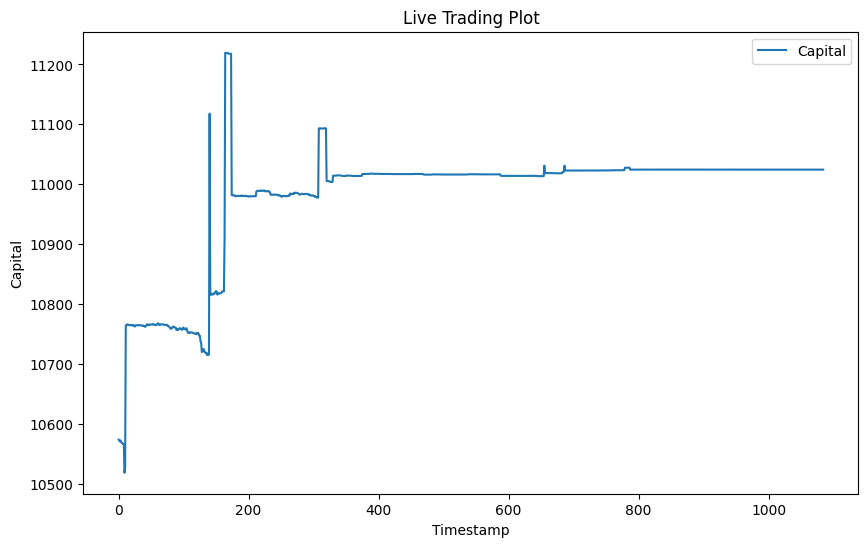

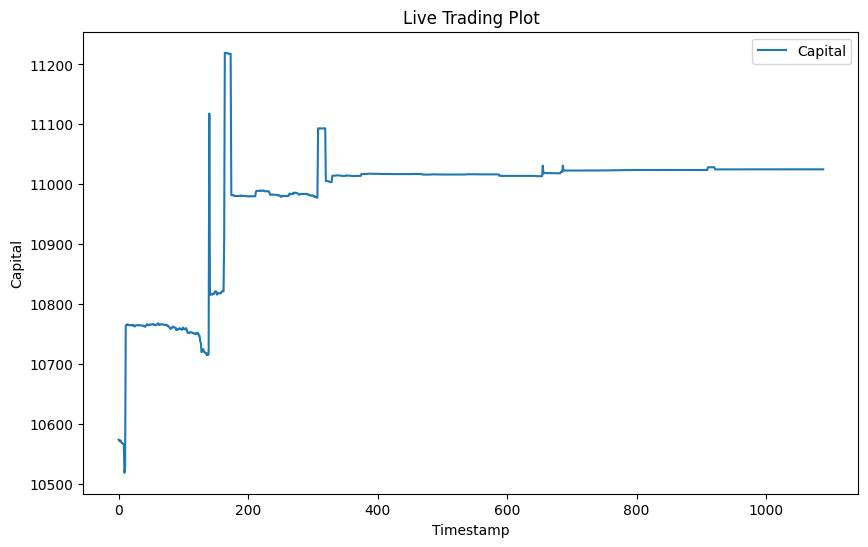

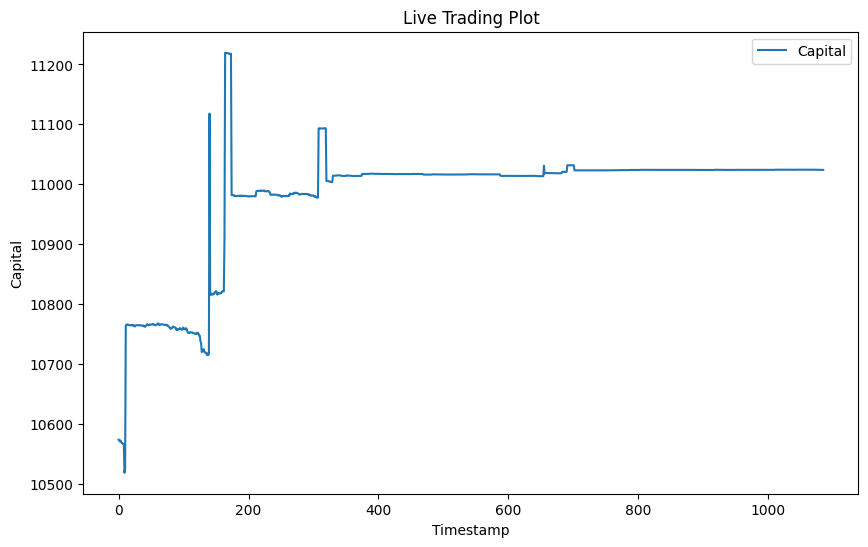

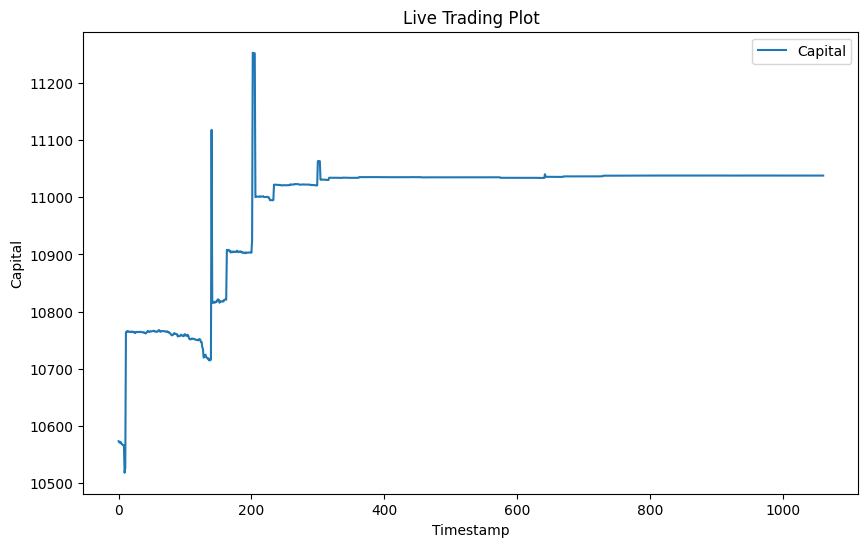

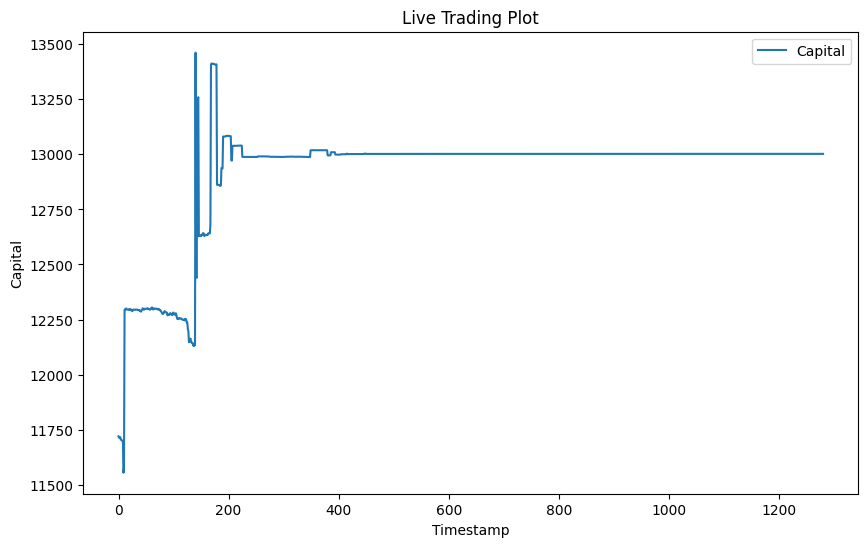

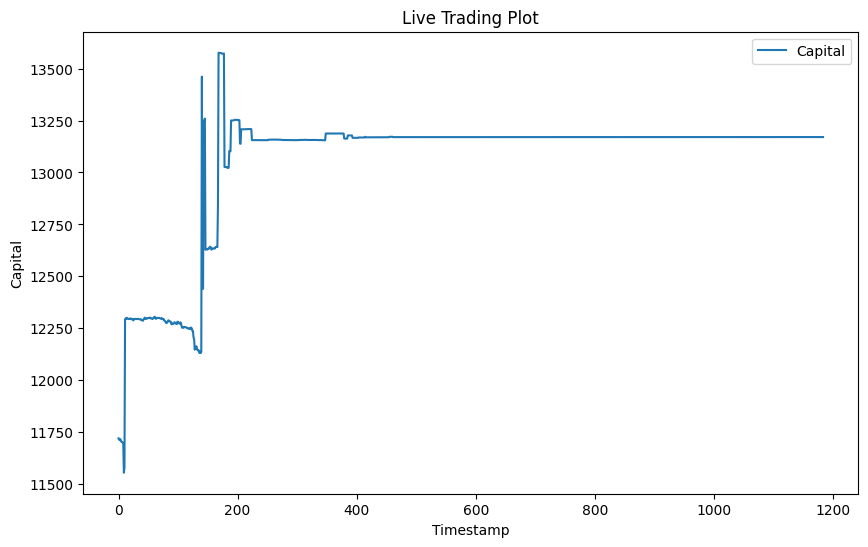

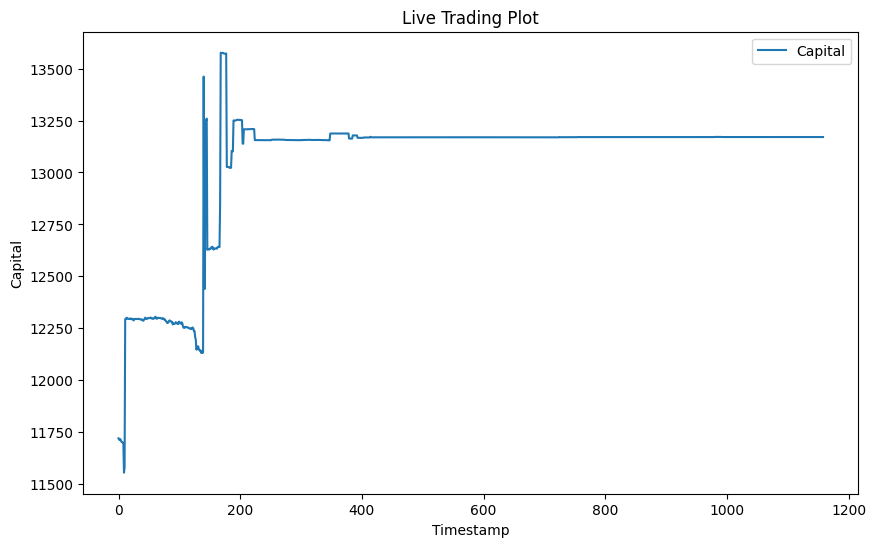

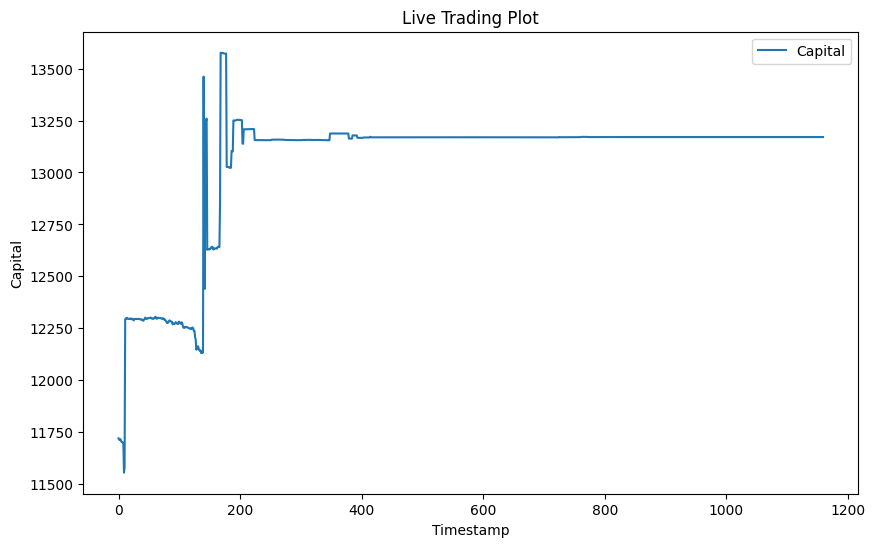

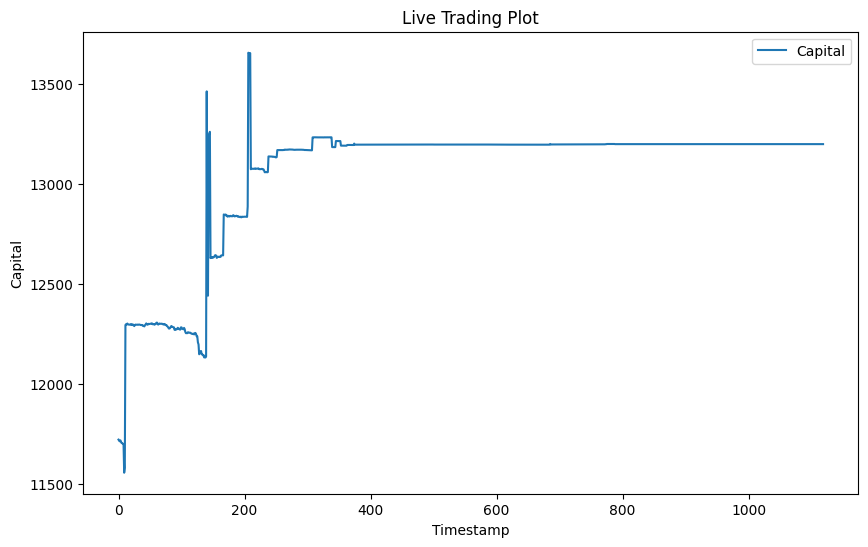

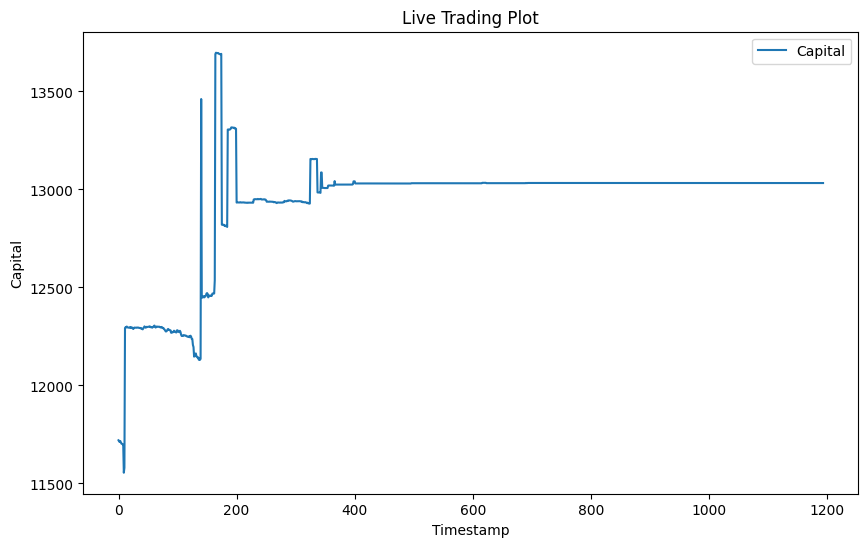

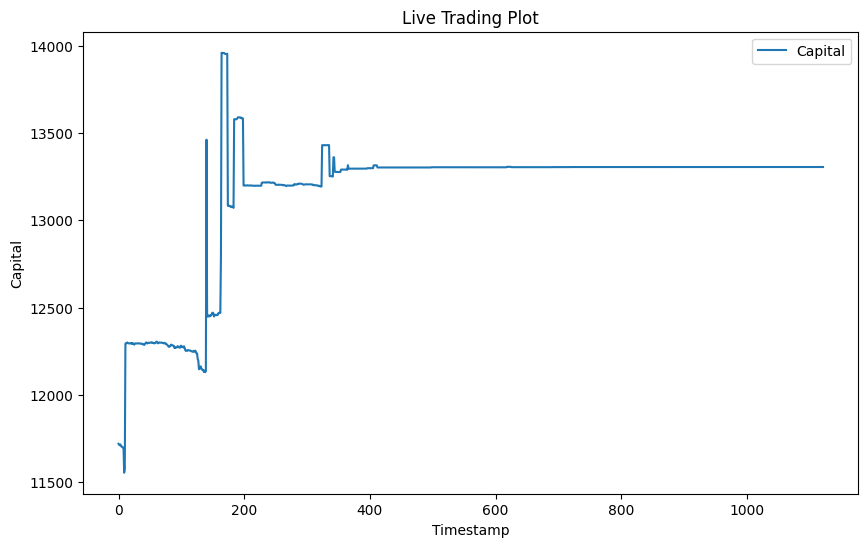

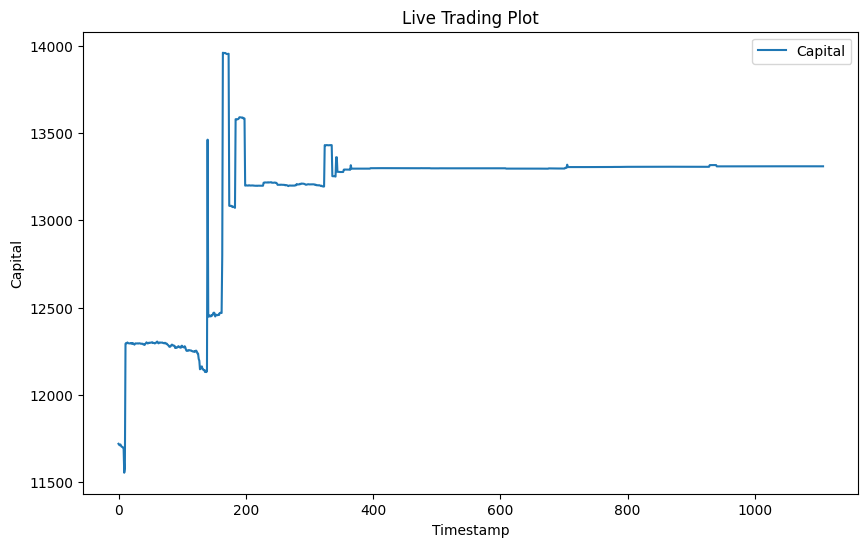

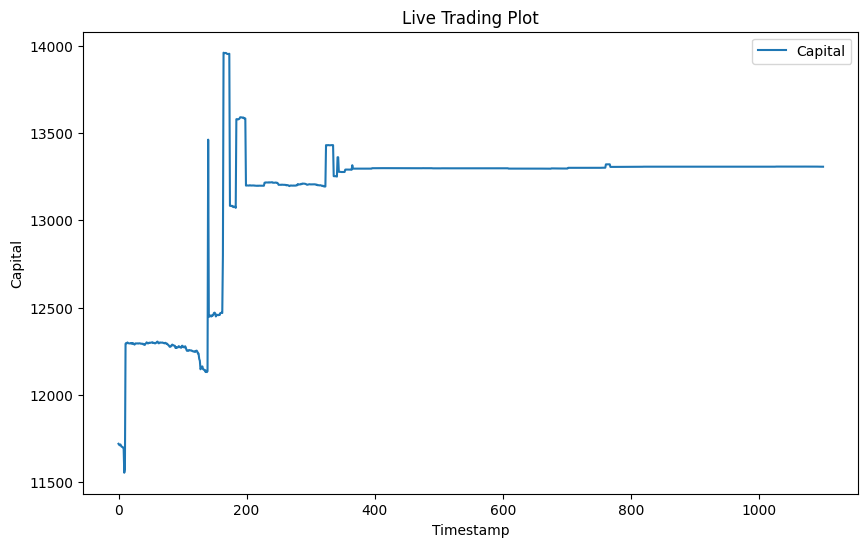

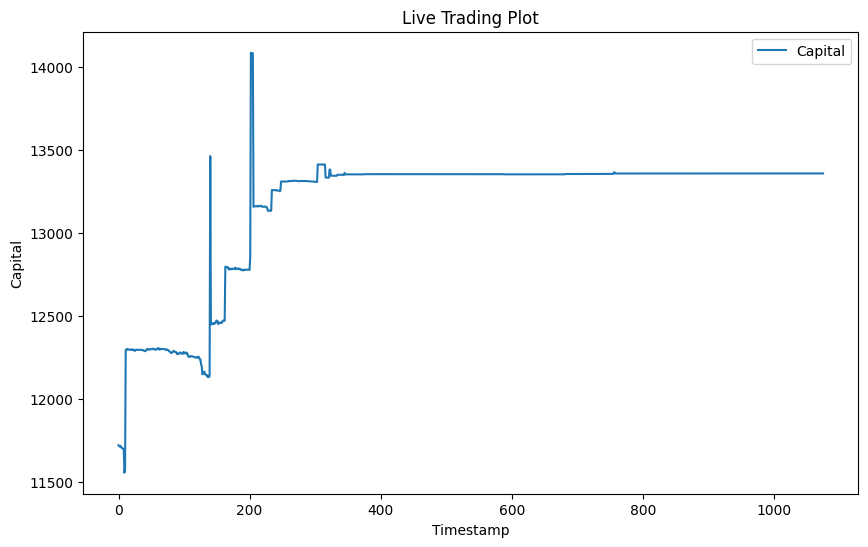

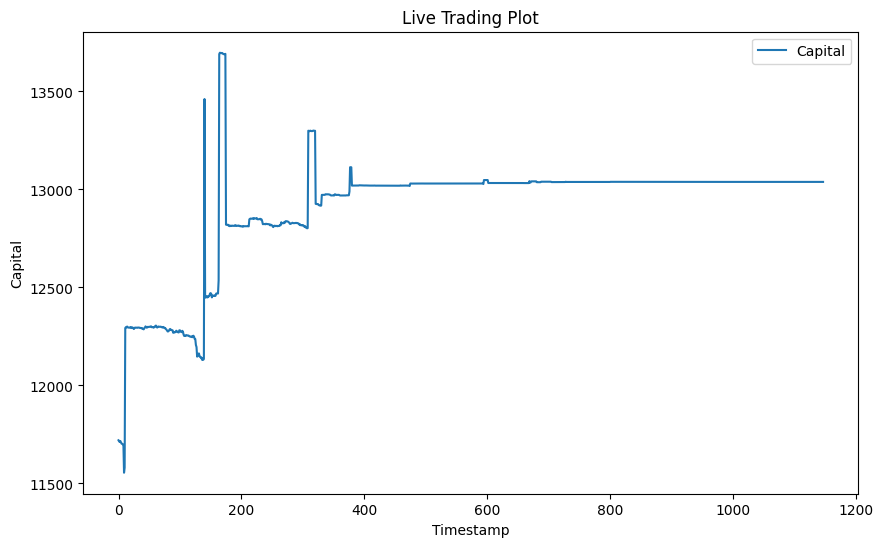

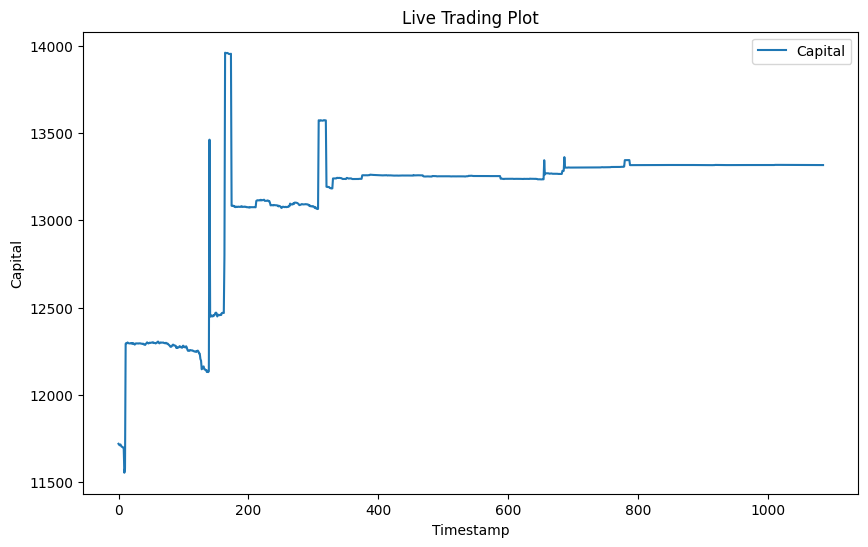

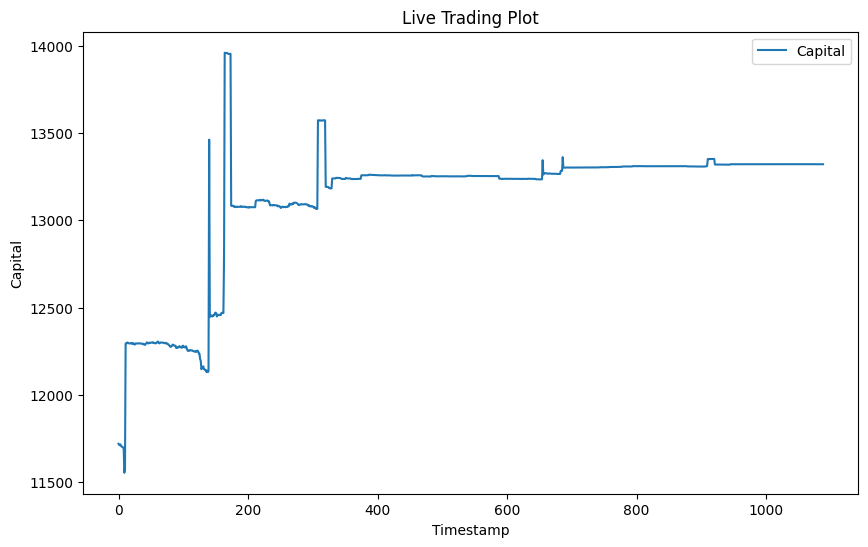

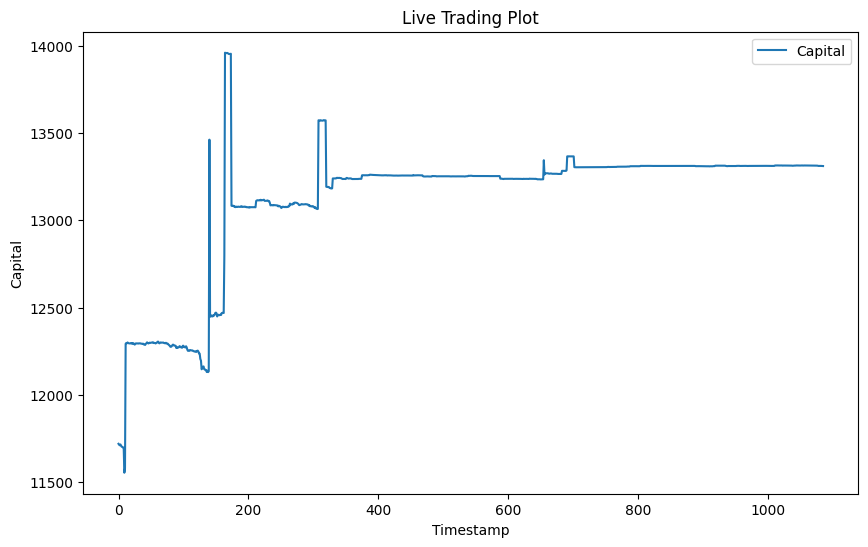

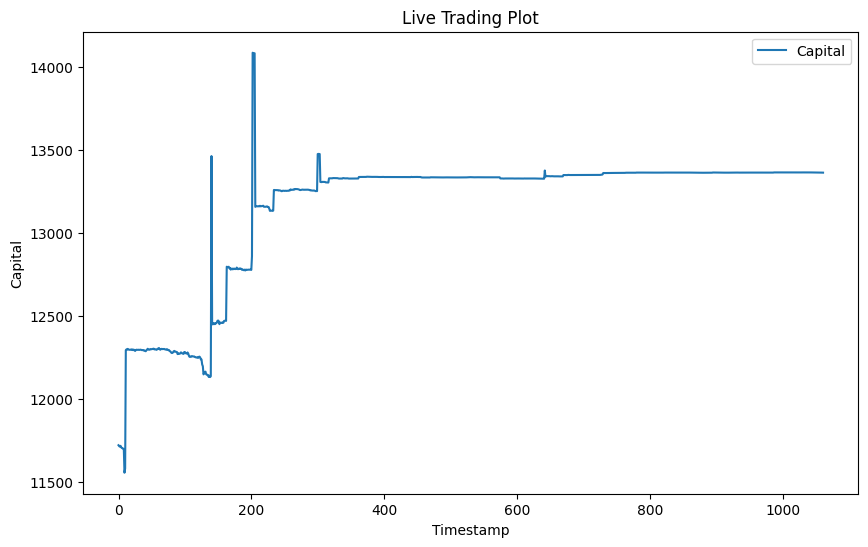

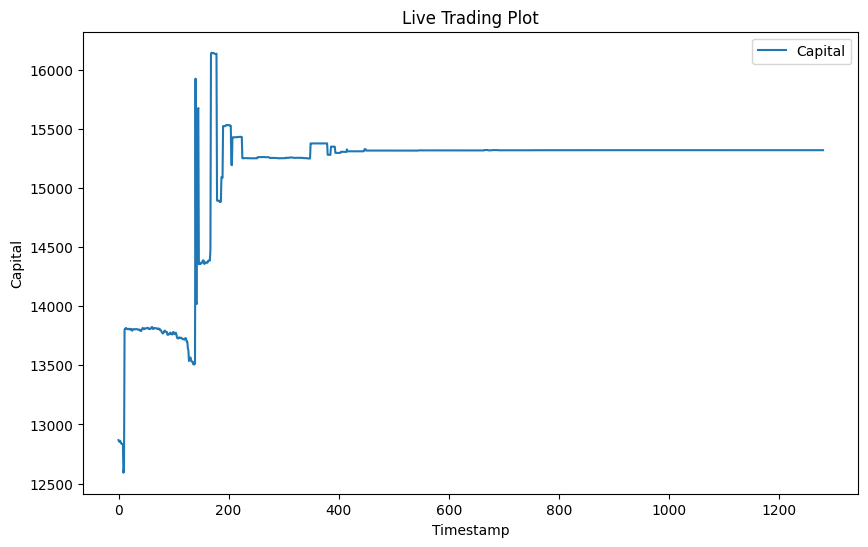

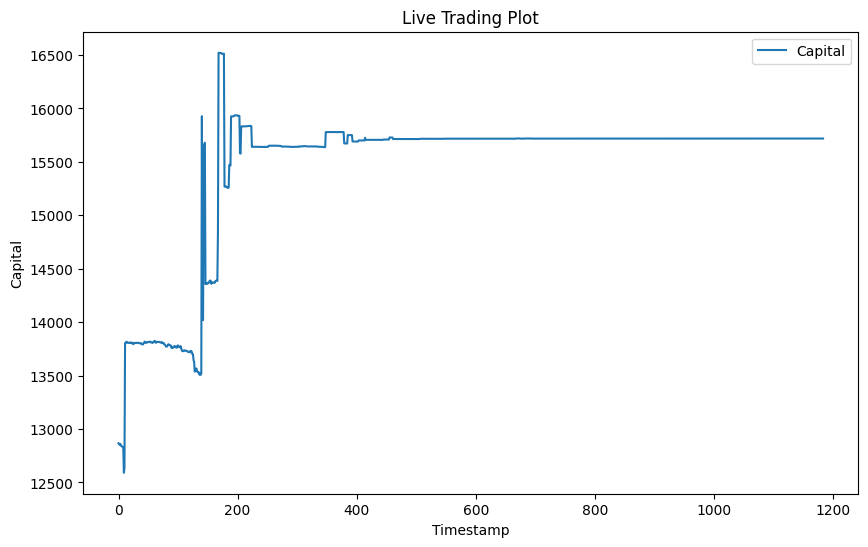

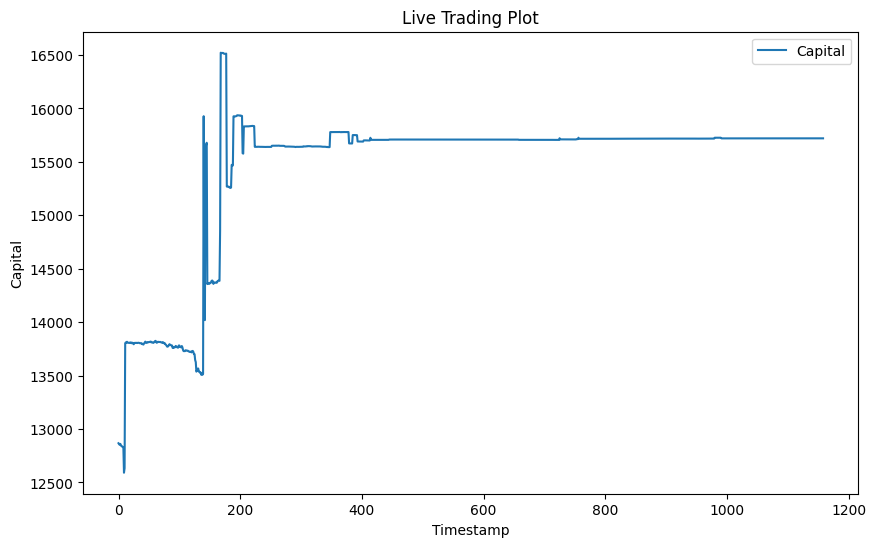

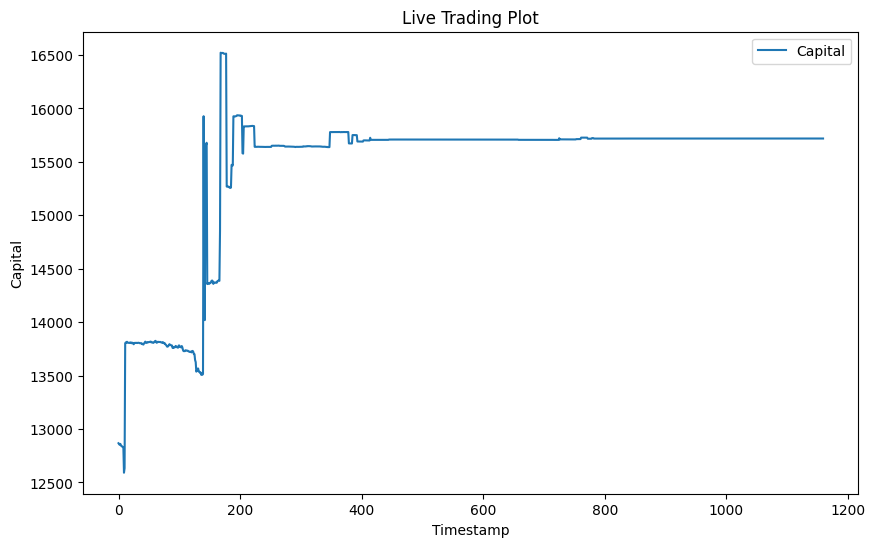

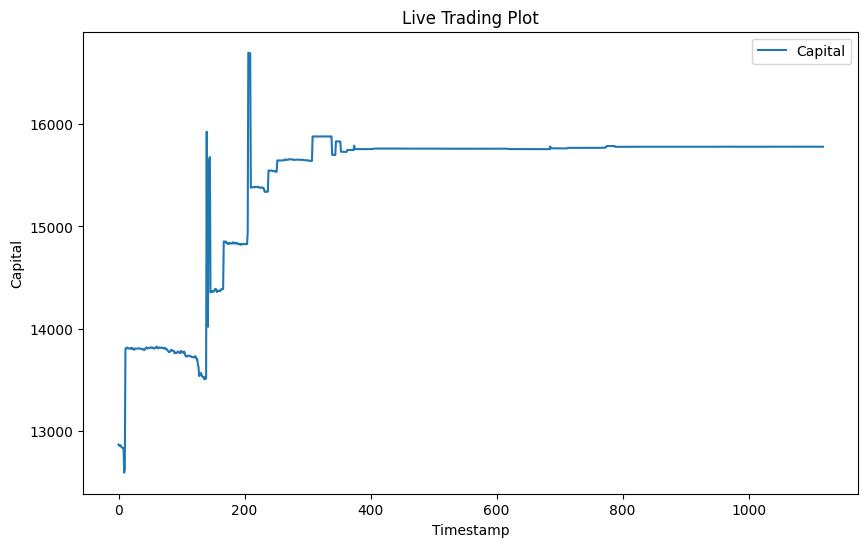

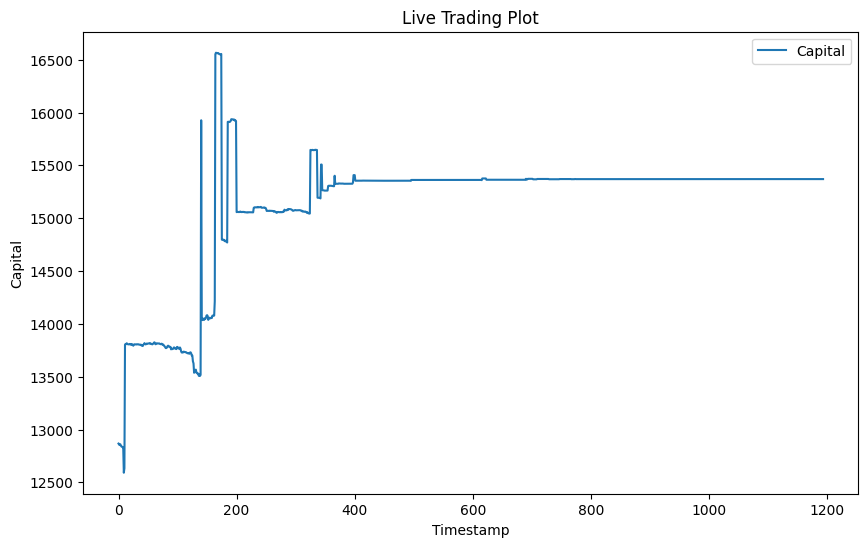

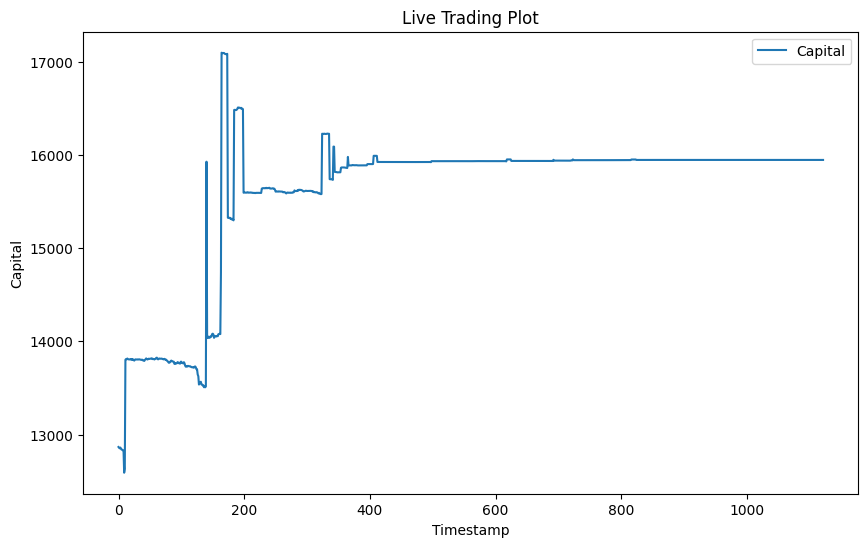

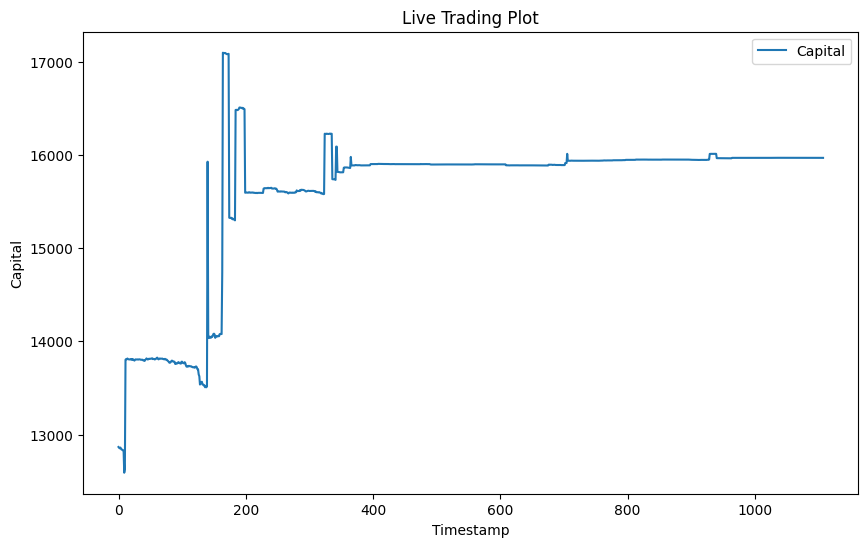

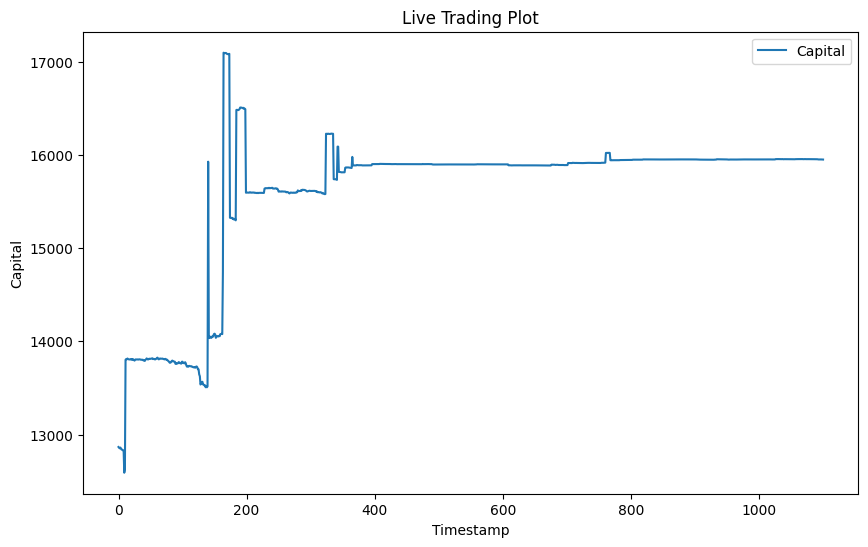

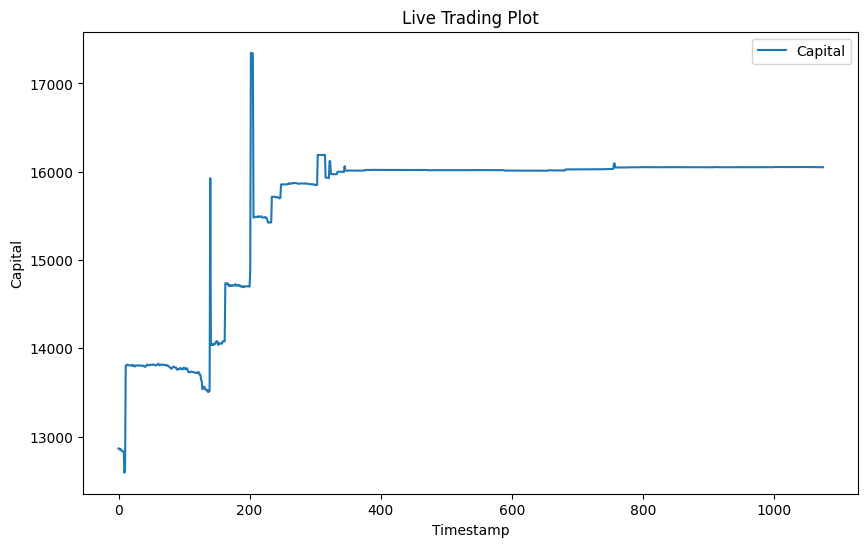

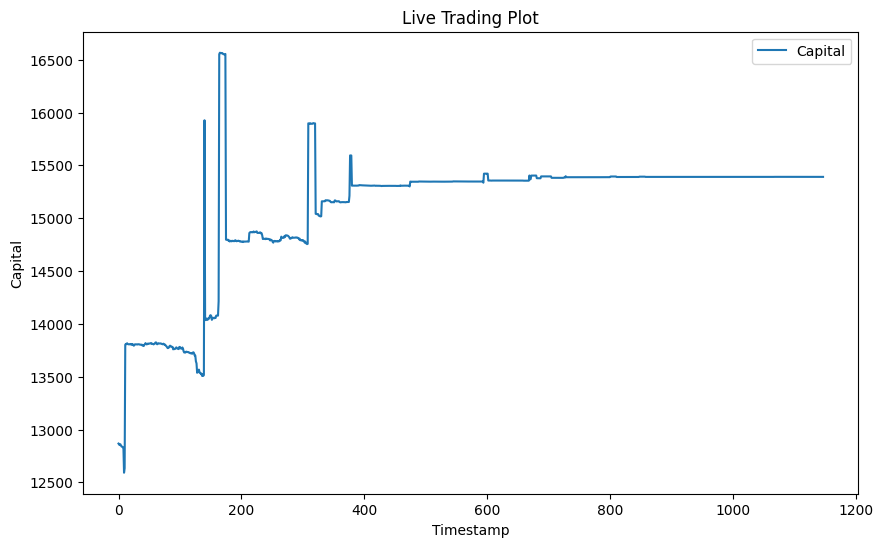

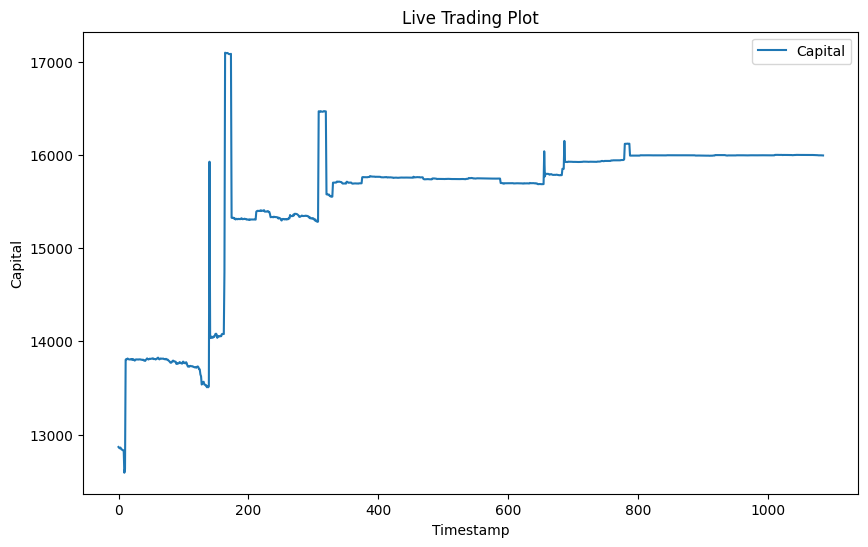

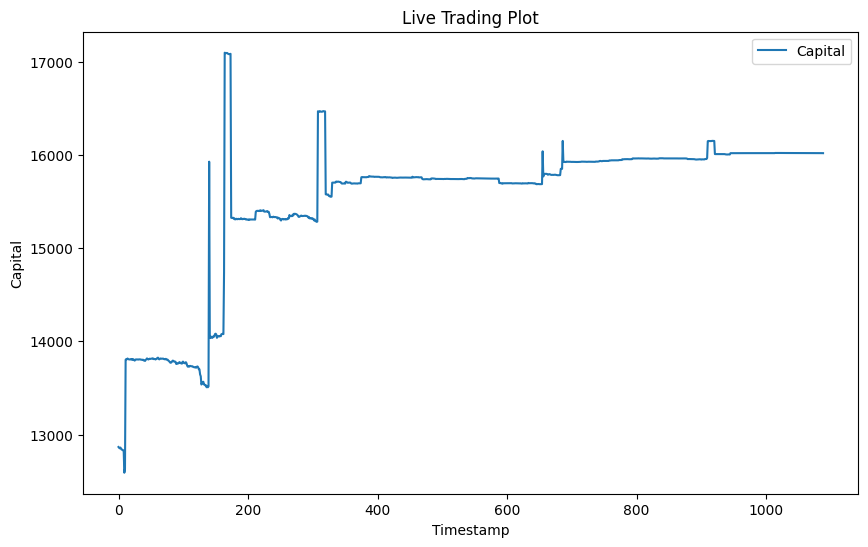

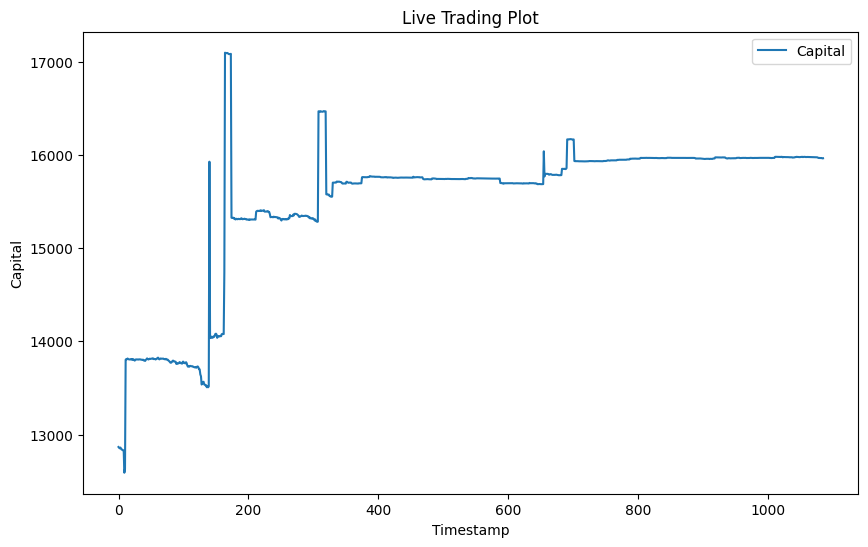

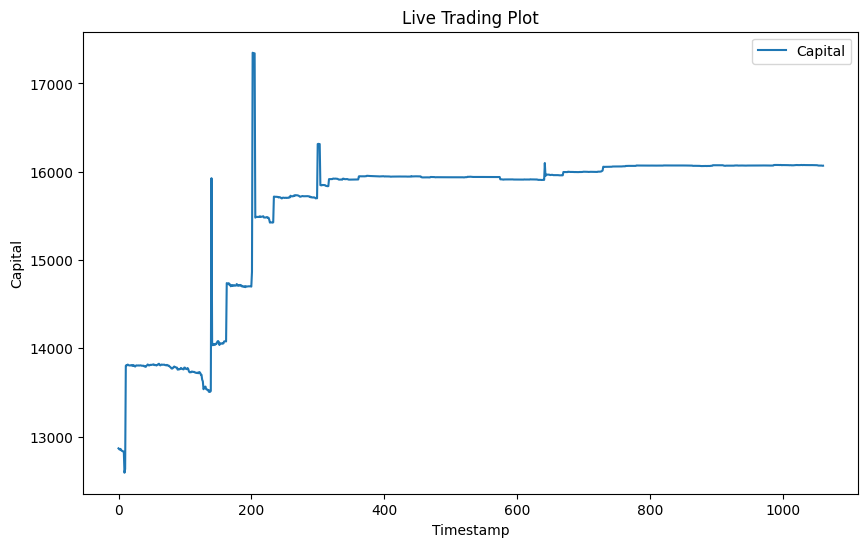

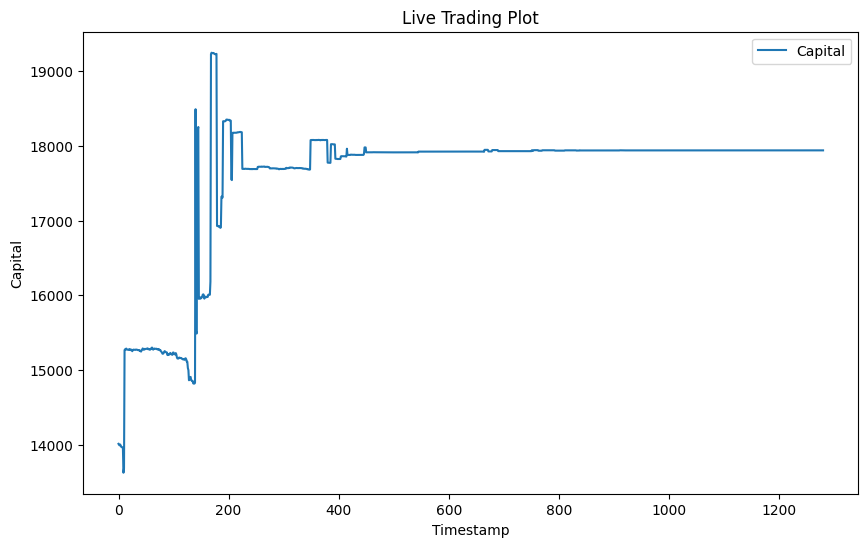

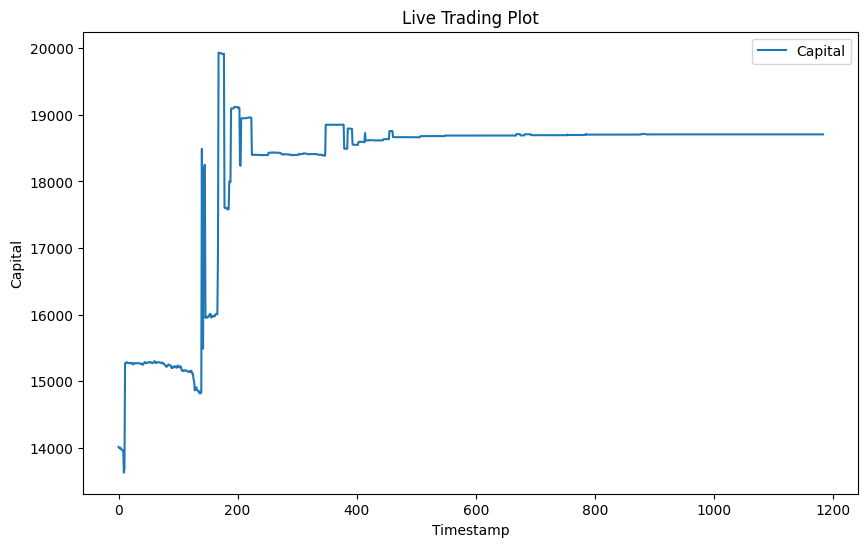

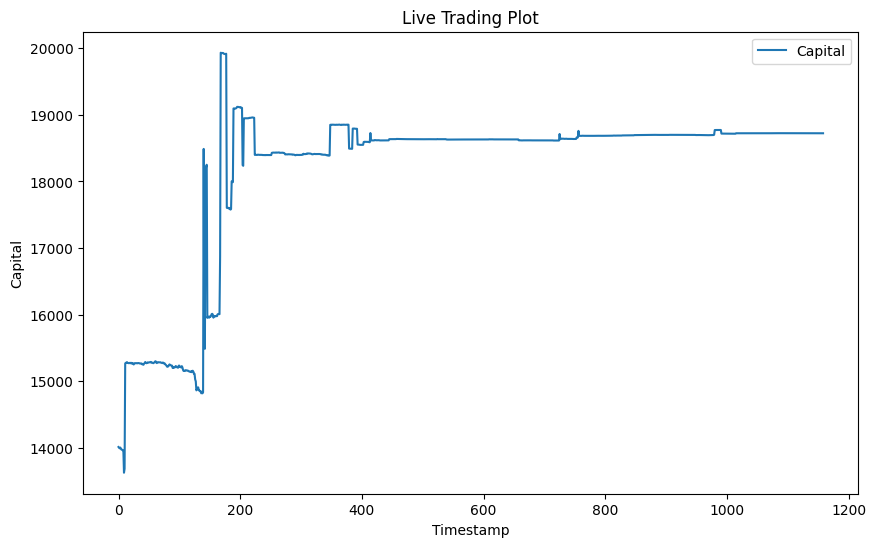

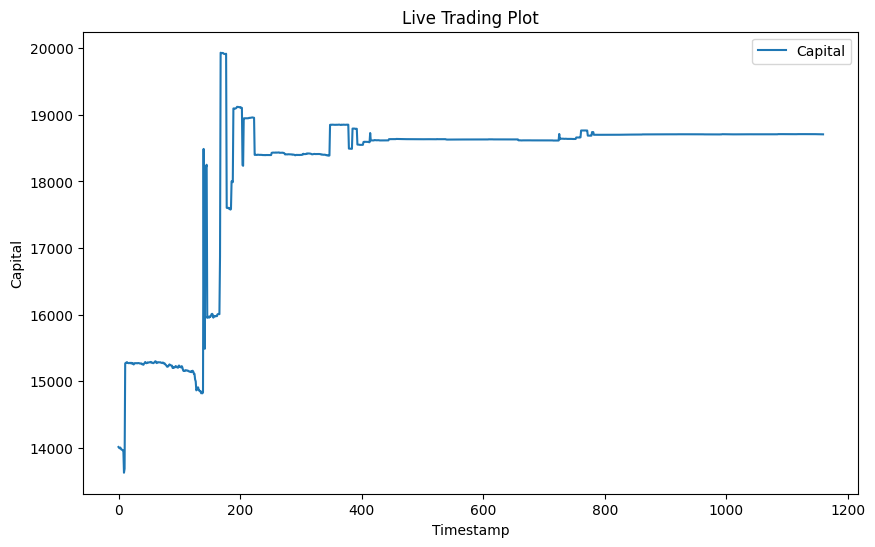

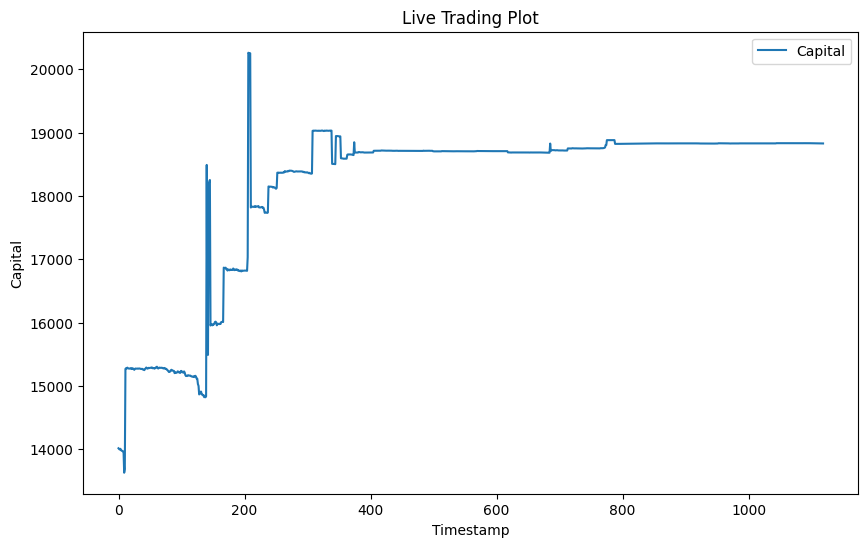

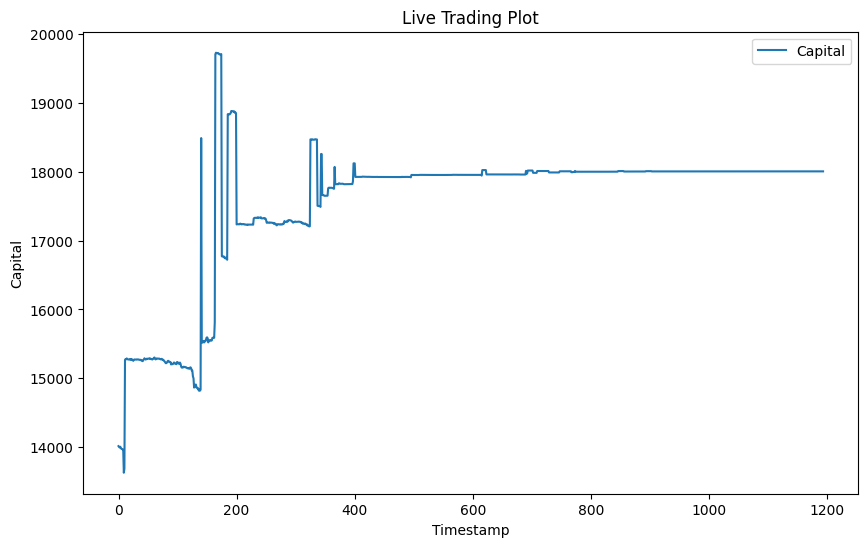

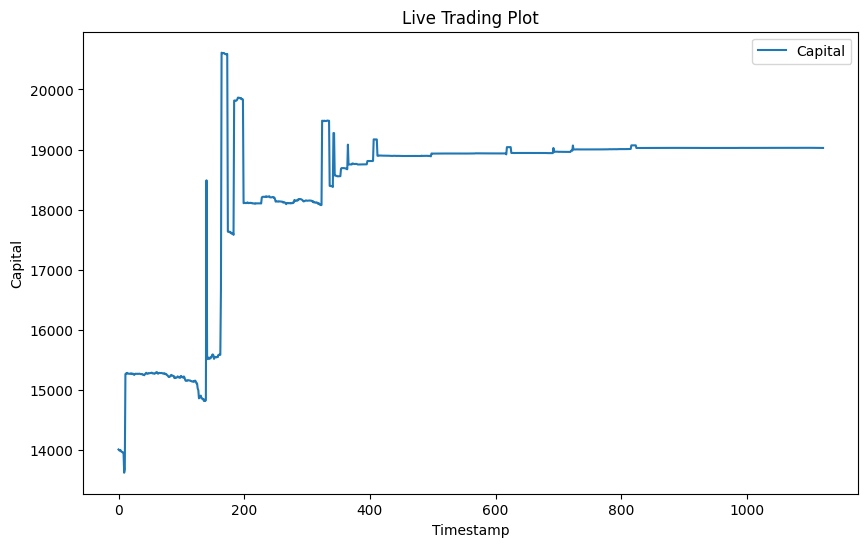

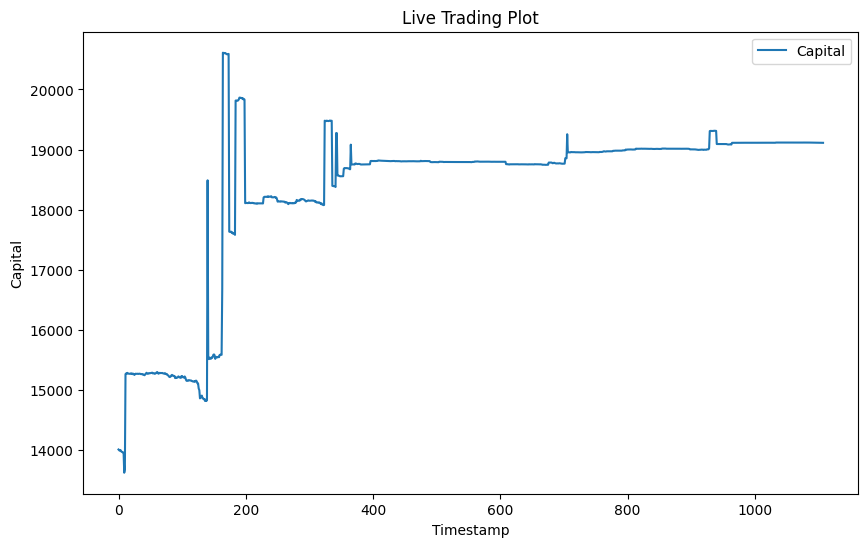

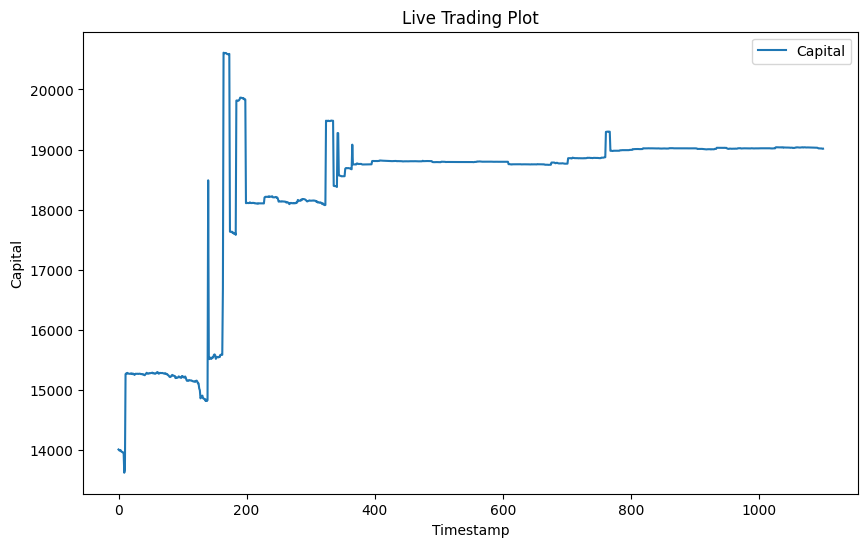

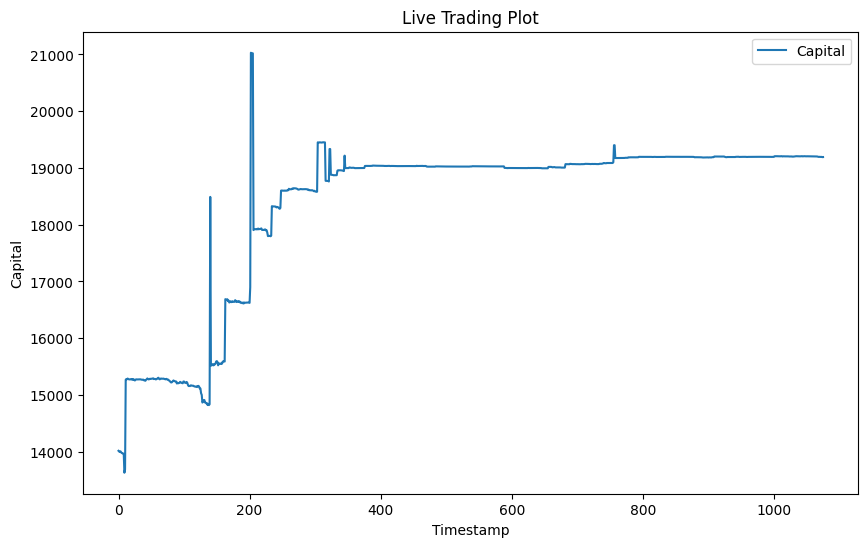

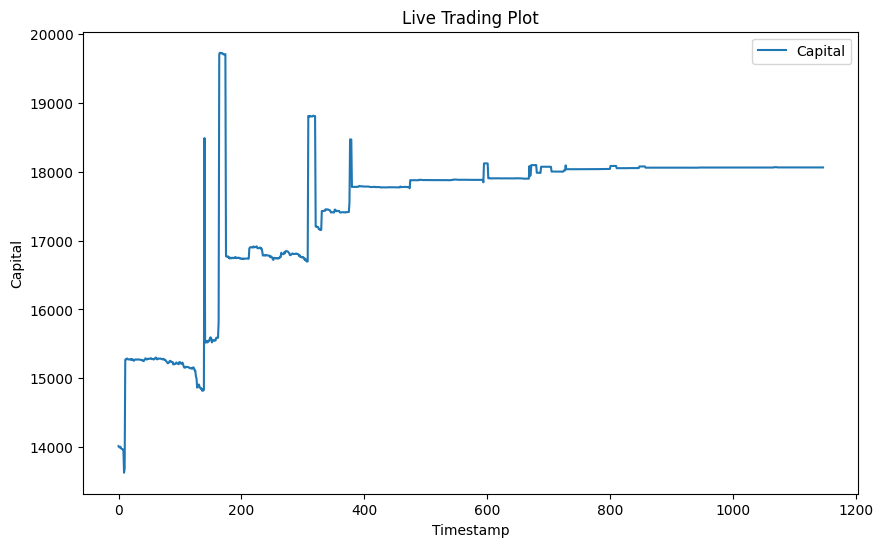

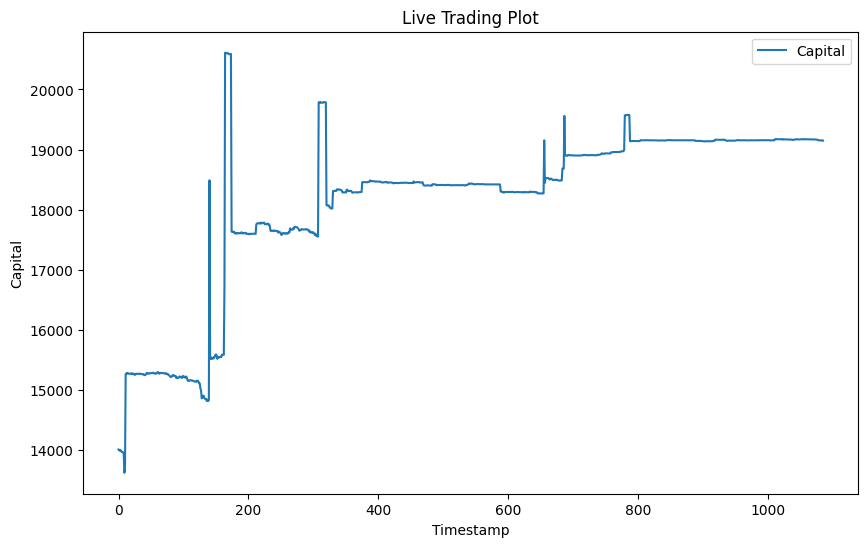

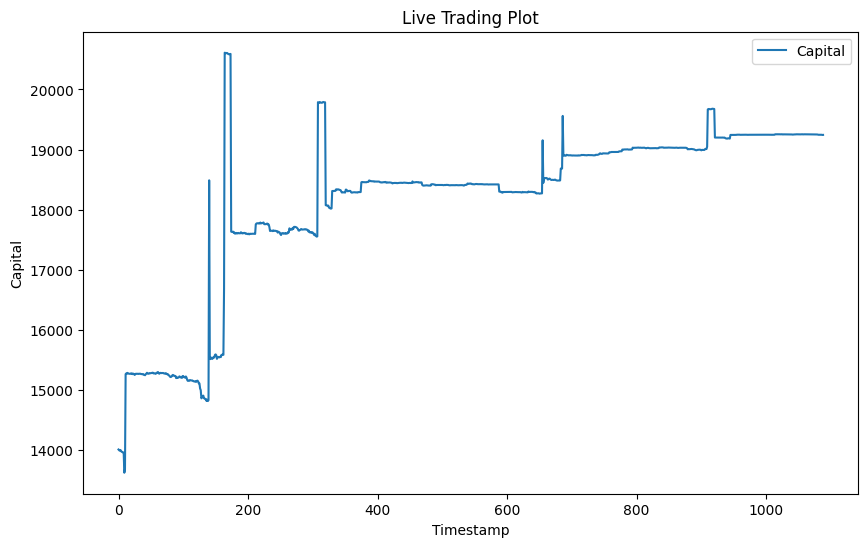

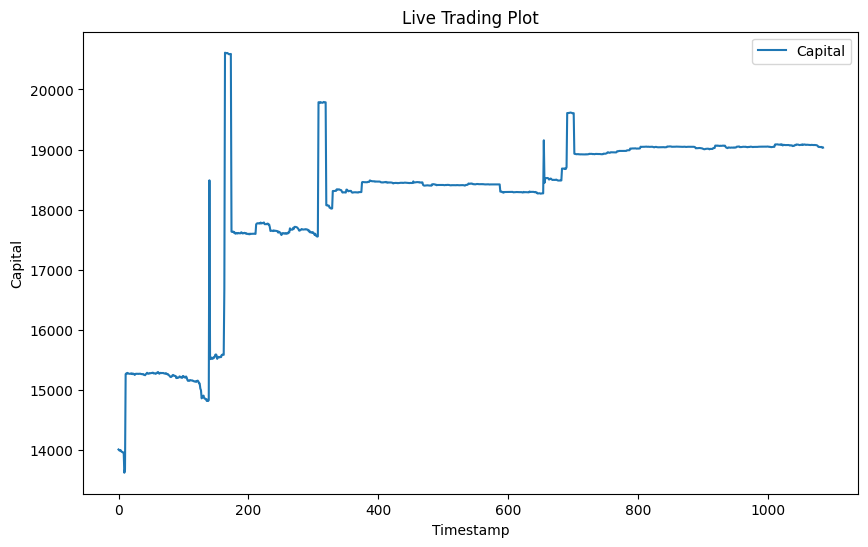

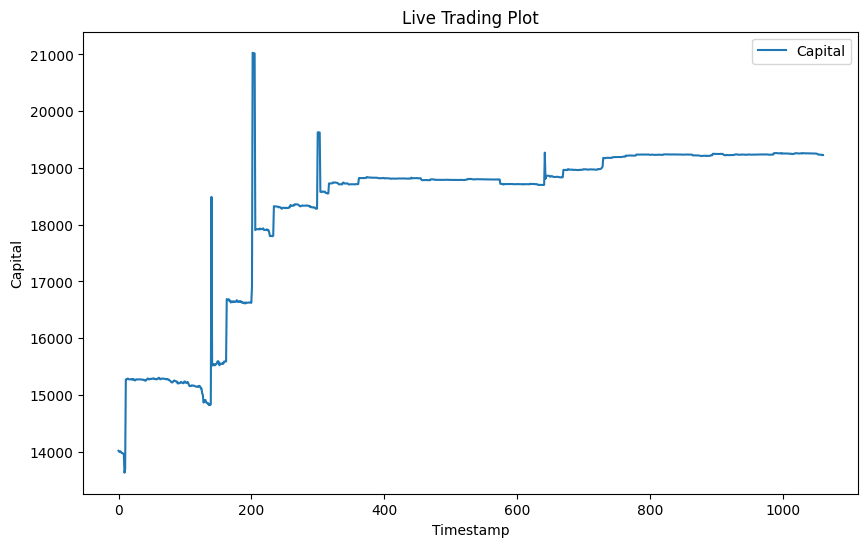

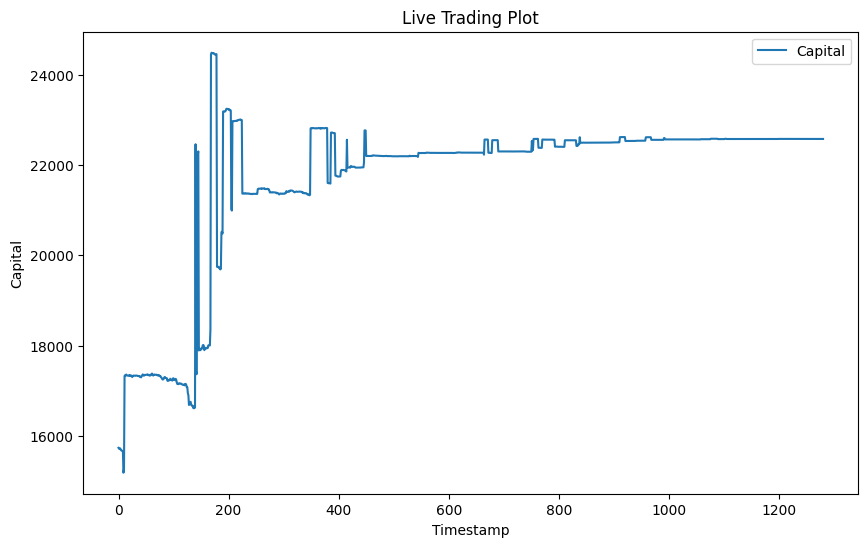

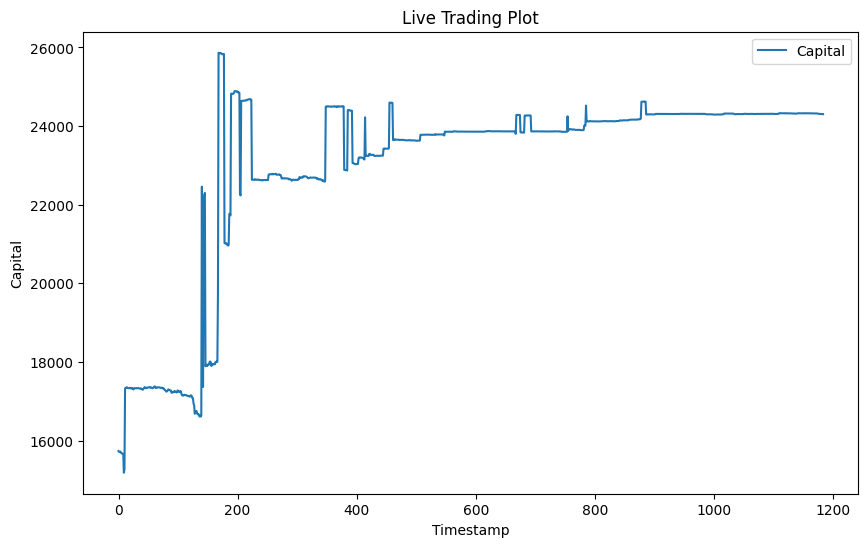

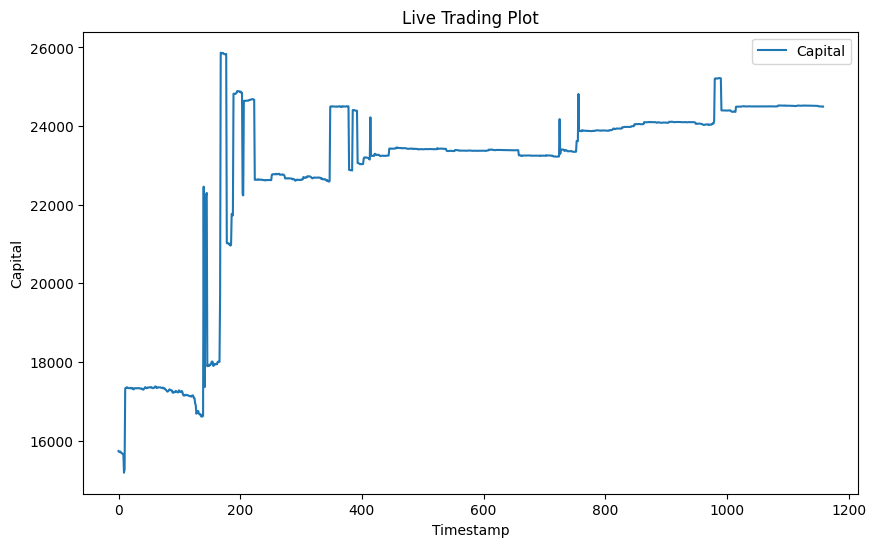

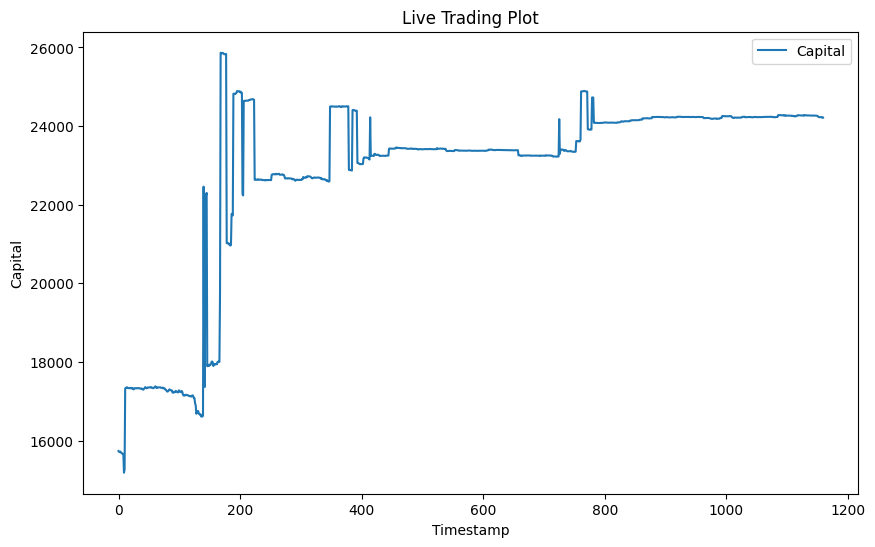

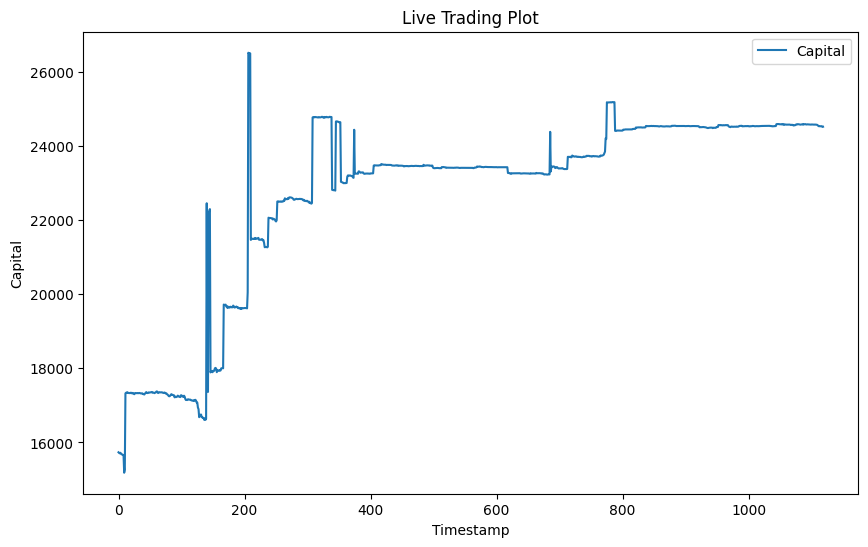

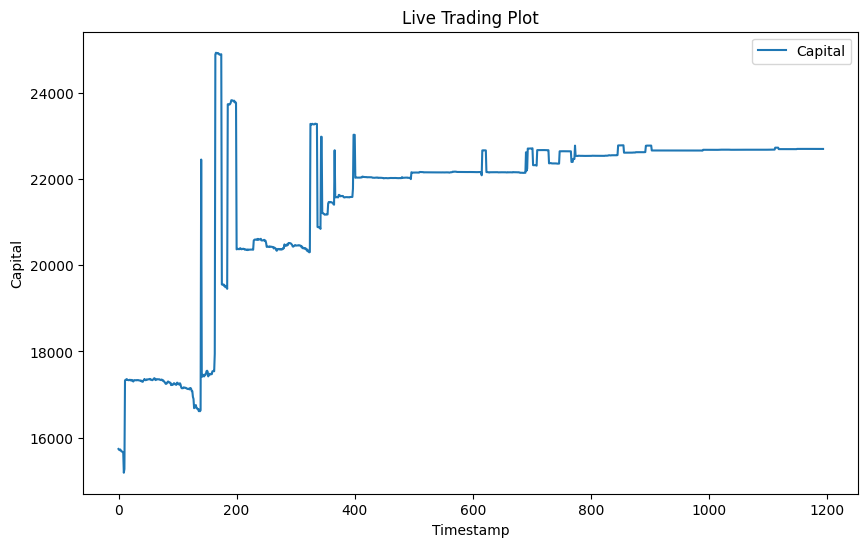

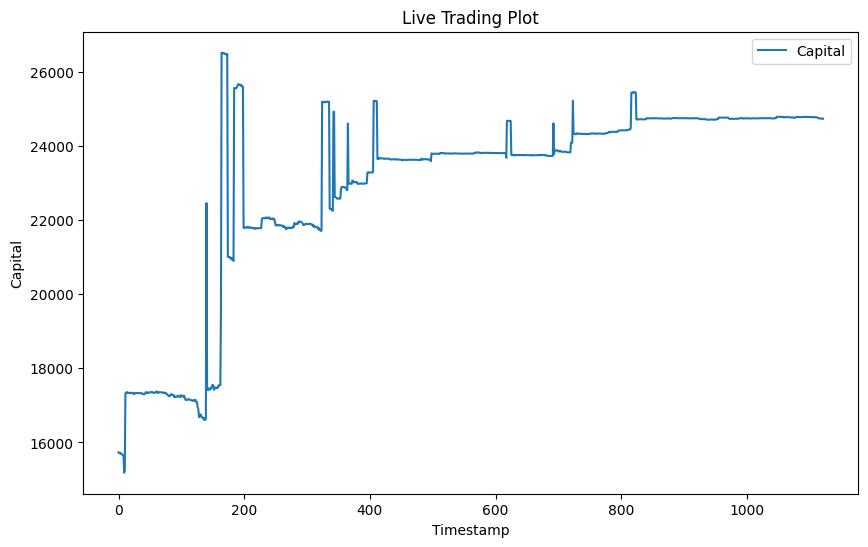

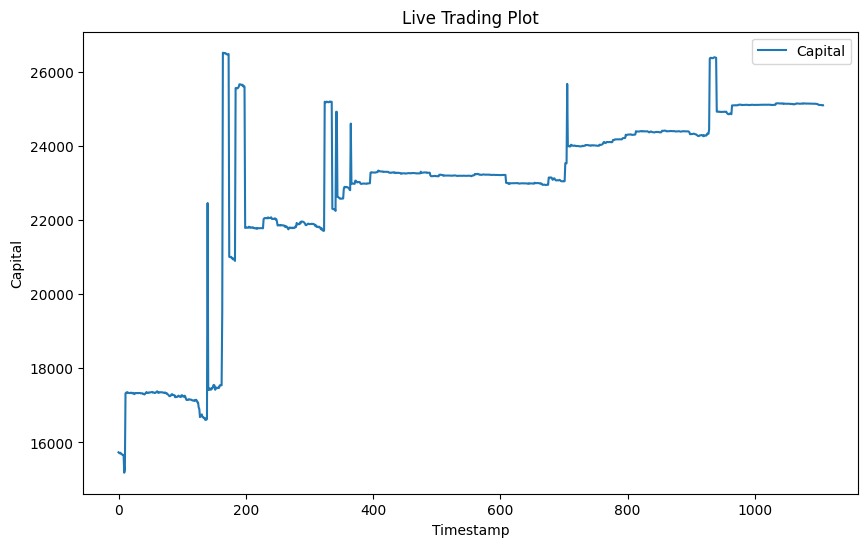

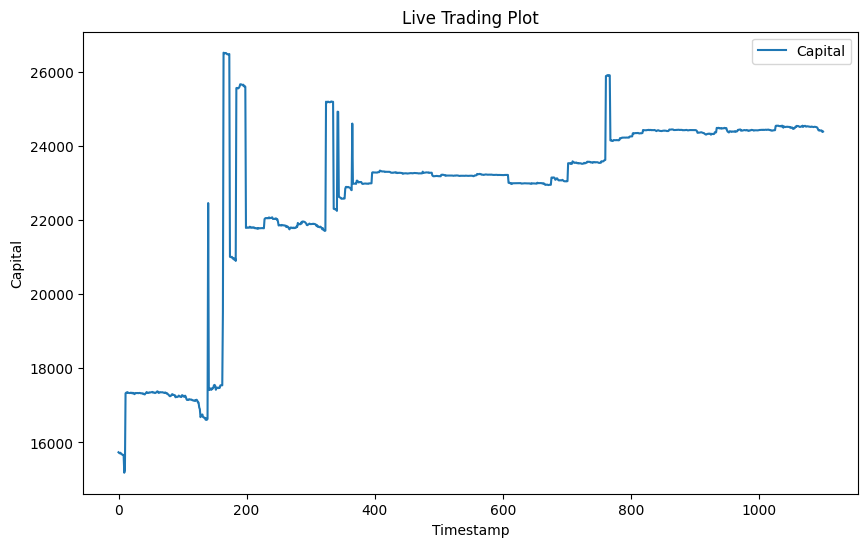

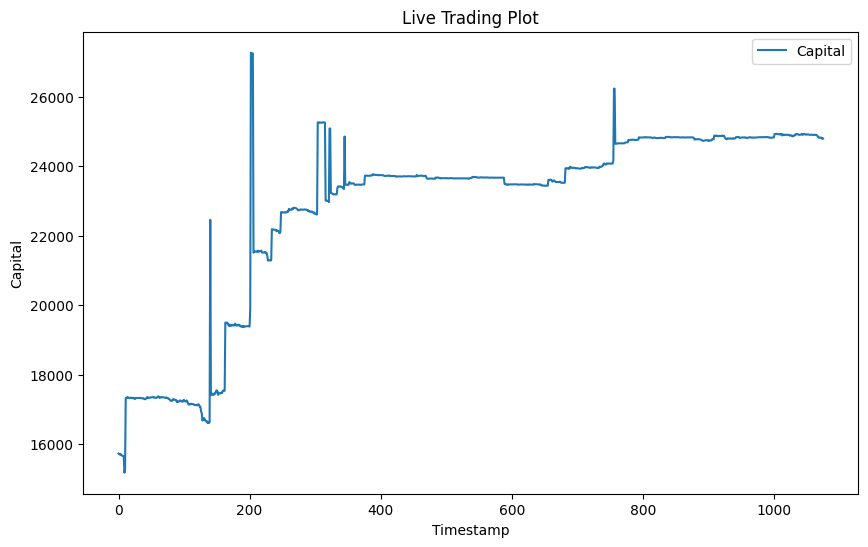

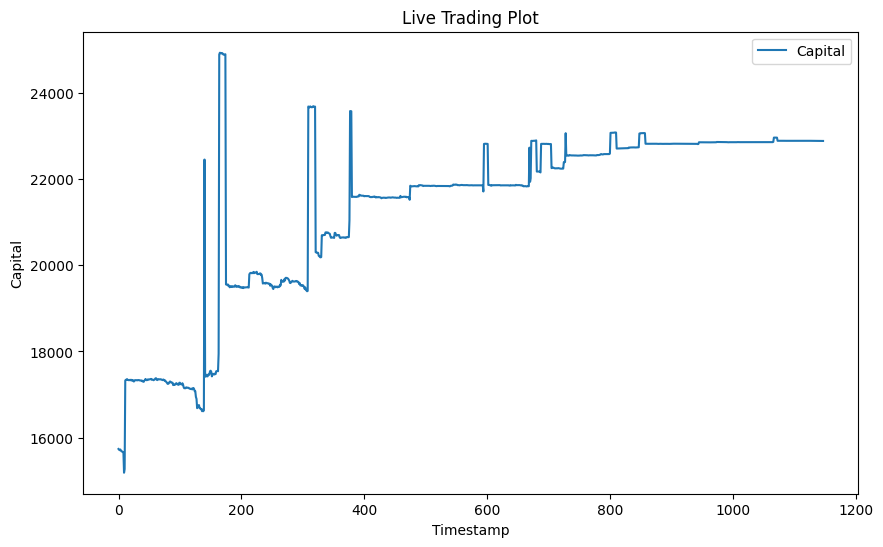

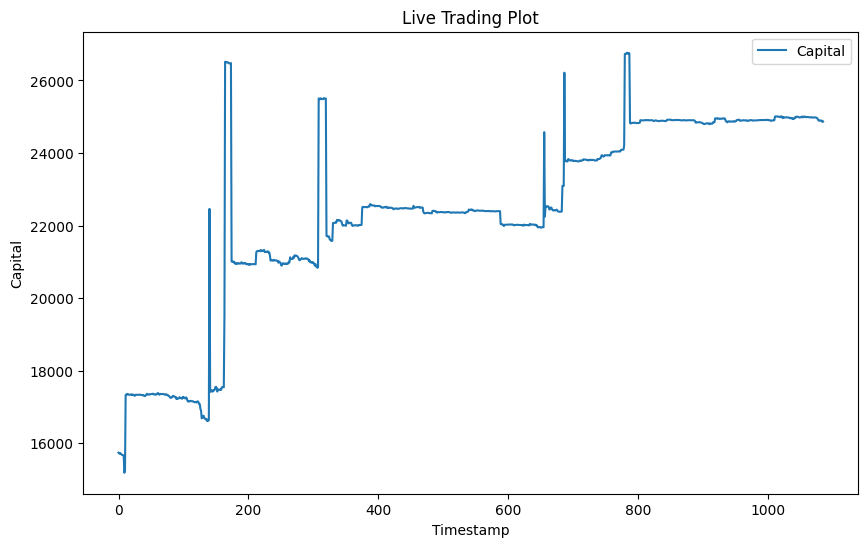

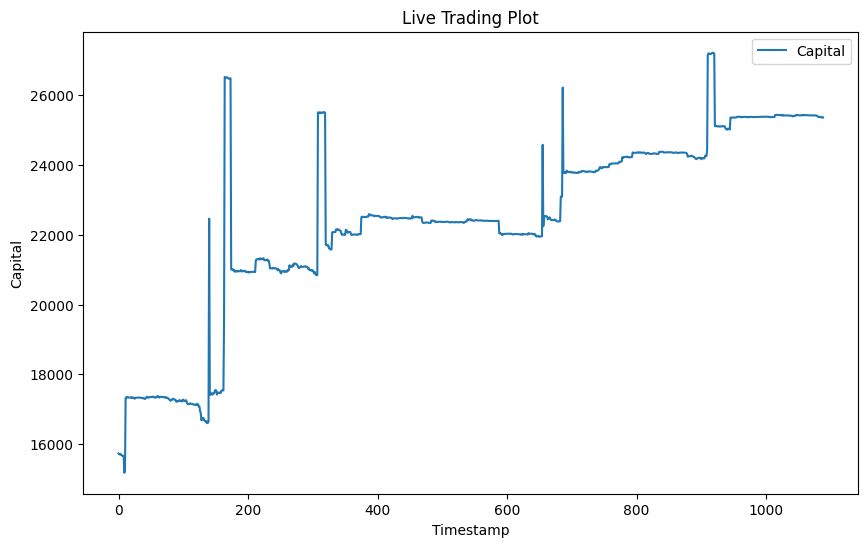

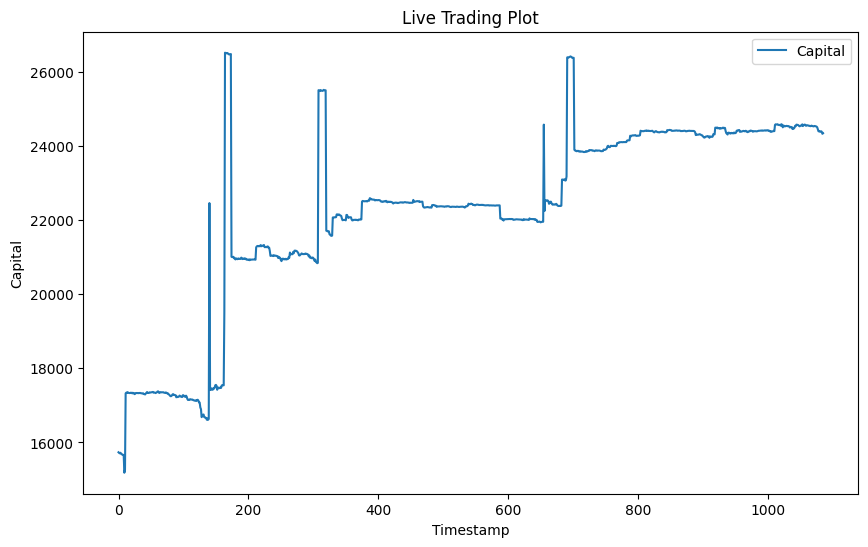

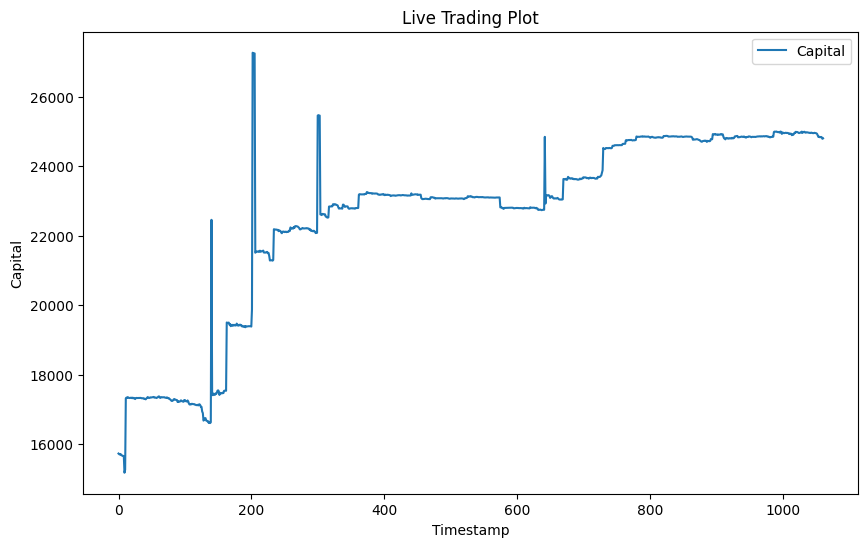

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')


class TechnicalIndicators:
    # Exponential Moving Average
    @staticmethod
    def ema(df, column, n):
        return pd.Series(df[column].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')

    # Rate of Change
    @staticmethod
    def roc(df, column, n):
        m = df[column].diff(n - 1)
        n = df[column].shift(n - 1)
        return pd.Series(((m / n) * 100), name=f'ROC_{n}')

    # Momentum
    @staticmethod
    def mom(df, column, n):
        return pd.Series(df[column].diff(n), name=f'Momentum_{n}')

    # Relative Strength Index
    @staticmethod
    def rsi(series, period):
        delta = series.diff().dropna()
        u = delta * 0
        d = u.copy()
        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]
        u[u.index[period - 1]] = np.mean(u[:period])
        u = u.drop(u.index[:(period - 1)])
        d[d.index[period - 1]] = np.mean(d[:period])
        d = d.drop(d.index[:(period - 1)])
        rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period - 1, adjust=False).mean()
        return 100 - 100 / (1 + rs)

    # Stochastic Oscillator %K
    @staticmethod
    def stok(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        return stok

    # Stochastic Oscillator %D
    @staticmethod
    def stod(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        stod = stok.rolling(3).mean()
        return stod

    # Moving Average
    @staticmethod
    def ma(df, n):
        ma = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name=f'ma_{n}')
        return ma


class LivePlot:
    def __init__(self, trade_history):
        self.trade_history = trade_history
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.set_title('Live Trading Plot')
        self.ax.set_xlabel('Timestamp')
        self.ax.set_ylabel('Capital')
        self.lines, = self.ax.plot([], [], label='Capital')
        self.ax.legend()
        self.update_plot()

    def update_plot(self):
        self.lines.set_xdata(range(len(self.trade_history)))
        self.lines.set_ydata(self.trade_history['capital'])
        self.ax.relim()
        self.ax.autoscale_view()
        display(self.fig)
        clear_output(wait=True)


class TradingStrategy:
    @staticmethod
    def implement(model, X, historical_data, position_size=1, stop_loss_percent=0.02, take_profit_percent=0.3):
        signals = model.predict(X)

        position = 0
        wallet = 10000
        trade_history = pd.DataFrame(columns=['timestamp', 'signal', 'price', 'quantity', 'capital', 'open', 'close',
                                              'high', 'low'])
        live_plot = LivePlot(trade_history)
        for i in range(len(signals)):
            if signals[i] == 1 and position == 0:  # Buy signal and no current position
                entry_price = historical_data['close'].iloc[i]
                position_size = wallet * position_size / entry_price
                wallet -= wallet * position_size
                position = 1
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '1',
                                                      'price': entry_price,
                                                      'quantity': position_size,
                                                      'capital': wallet + position_size * entry_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)
            elif signals[i] == -1 and position == 0:  # Sell signal and no current position
                entry_price = historical_data['close'].iloc[i]
                position_size = wallet * position_size / entry_price
                wallet += wallet * position_size
                position = -1
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '-1',
                                                      'price': entry_price,
                                                      'quantity': position_size,
                                                      'capital': wallet - position_size * entry_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)
            elif signals[i] == 0 and position != 0:  # Hold signal and there is an open position
                if position == 1:  # Check for stop loss or take profit conditions for long position
                    current_price = historical_data['close'].iloc[i]
                    if current_price <= entry_price * (1 - stop_loss_percent) or current_price >= entry_price * (
                            1 + take_profit_percent):
                        wallet += position_size * current_price
                        position = 0
                        trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '-1',
                                                              'price': current_price,
                                                              'quantity': position_size,
                                                              'capital': wallet,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)
                elif position == -1:  # Check for stop loss or take profit conditions for short position
                    current_price = historical_data['close'].iloc[i]
                    if current_price >= entry_price * (1 - stop_loss_percent) or current_price <= entry_price * (
                            1 + take_profit_percent):
                        wallet -= position_size * current_price
                        position = 0
                        trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '1',
                                                              'price': current_price,
                                                              'quantity': position_size,
                                                              'capital': wallet,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)
            else:
                current_price = historical_data['close'].iloc[i]
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '0',
                                                      'price': current_price,
                                                      'quantity': position_size,
                                                      'capital': wallet + position_size * current_price,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)

        # Close any remaining open position at the end
        if position != 0:
            current_price = historical_data['close'].iloc[-1]
            wallet += position_size * current_price
            trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[-1],
                                                  'signal': '-1' if position == 1 else '1',
                                                  'price': current_price,
                                                  'quantity': position_size,
                                                  'capital': wallet,
                                                  'open': historical_data['open'].iloc[-1],
                                                  'close': historical_data['close'].iloc[-1],
                                                  'high': historical_data['high'].iloc[-1],
                                                  'low': historical_data['low'].iloc[-1]},
                                                 ignore_index=True)

        live_plot.trade_history = trade_history
        live_plot.update_plot()
        return trade_history




def create_technical_indicators(dataset):
    tech_indicators = TechnicalIndicators()

    dataset['MOM10'] = tech_indicators.mom(dataset, 'close', 10)
    dataset['MOM30'] = tech_indicators.mom(dataset, 'close', 30)
    dataset['ROC10'] = tech_indicators.roc(dataset, 'close', 10)
    dataset['ROC30'] = tech_indicators.roc(dataset, 'close', 30)
    dataset['EMA10'] = tech_indicators.ema(dataset, 'close', 10)
    dataset['EMA30'] = tech_indicators.ema(dataset, 'close', 30)
    dataset['EMA200'] = tech_indicators.ema(dataset, 'close', 200)
    dataset['RSI10'] = tech_indicators.rsi(dataset['close'], 10)
    dataset['RSI30'] = tech_indicators.rsi(dataset['close'], 30)
    dataset['RSI200'] = tech_indicators.rsi(dataset['close'], 200)
    dataset['%K10'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%D10'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%K30'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%D30'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%K200'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['%D200'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['MA21'] = tech_indicators.ma(dataset, 10)
    dataset['MA63'] = tech_indicators.ma(dataset, 30)
    dataset['MA252'] = tech_indicators.ma(dataset, 200)

    return dataset


def create_target_variable(df, look_forward_period=1):
    df['target'] = df['close'].shift(-look_forward_period) >= df['close']
    df['target'] = df['target'].astype(int)


def build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid):
    etc_model = ExtraTreesClassifier(random_state=42)

    grid = GridSearchCV(estimator=etc_model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_result = grid.fit(X_train, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    ranks = grid_result.cv_results_['rank_test_score']
    for mean, stdev, param, rank in zip(means, stds, params, ranks):
        print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

    best_params = grid_result.best_params_
    etc_model.set_params(**best_params)
    etc_model.fit(X_train, y_train)

    predictions = etc_model.predict(X_test)

    print("\nFinal Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

    return etc_model


# Load data from CSV file
df = pd.read_csv('/content/Final_dataset_2_1.csv')
df.rename(columns={'Date': 'timestamp', 'Open': 'open', 'Close': 'close', 'High': 'high',
                   'Low': 'low'}, inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)





# Create technical indicators
df = create_technical_indicators(df)

# Create target variable
create_target_variable(df)

# Drop rows with NaN values resulting from creating technical indicators
df = df.dropna()

# Features and target variable
X_train = df.iloc[:int(0.7 * len(df))].drop(['timestamp', 'target'], axis=1)
y_train = df.iloc[:int(0.7 * len(df))]['target']

X_test = df.iloc[int(0.7 * len(df)):].drop(['timestamp', 'target'], axis=1)
y_test = df.iloc[int(0.7 * len(df)):]['target']

df_test = df.iloc[int(0.7 * len(df)):]

# Fine-tune parameters with Grid Search
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'criterion': ['gini', 'entropy']
}

# Build and evaluate the model
model = build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid)

# Implement trading strategy
trade_history = TradingStrategy.implement(model, X_test, df_test)

# Print trade history
print("\nTrade History:")
print(trade_history)

# Save trade history to CSV
trade_history.to_csv('/content/trade_history.csv', index=False)


total_closed_trades = len(trade_history[trade_history['signal'] == '-1'])

winning_trades = trade_history[trade_history['signal'] == '1']
losing_trades = trade_history[trade_history['signal'] == '-1']
net_1 = winning_trades['capital']
net_2 = losing_trades['capital']
net_trade_value = []
mtr = 0
mmtr = 1000000000
max_drawdown1=0
for i in range(len(net_1)):
    j = net_2.iloc[i] - net_1.iloc[i]
    net_trade_value.append(j)
    if j<0 :
      if max_drawdown1 > j:
          mtr = net_1.iloc[i]
          mmtr = net_2.iloc[i]
          max_drawdown1 = j




gross_profit1=[]
gross_loss1=[]
# max_drawdown1=0
count=0
for val in net_trade_value:
  if val > 0:
    gross_profit1.append(val)
    count+=1
  else:
    gross_loss1.append(val)
    # max_drawdown1=min(max_drawdown1,val)

gross_profit_val = np.sum(gross_profit1)
gross_loss_val = np.sum(gross_loss1)


gross_profit = gross_profit_val
gross_loss = gross_loss_val
net_profit = gross_profit + gross_loss
max_drawdown = max_drawdown1
total_closed_trades = len(losing_trades)
win_rate = ( count / total_closed_trades) * 100
max_drowdown_percentage= (mtr-mmtr)/mtr *100
average_annual_returns = ((net_profit)/10000)*100

print("Requested Metrics for Model:")
print("1. Gross Profit: ${:,.2f}".format(gross_profit))
print("2. Net Profit: ${:,.2f}".format(net_profit))
print("3. Total Closed Trades: {}".format(total_closed_trades))
print("4. Win Rate (Profitability %): {:.2f}%".format(win_rate))
print("5. Max Drawdown: ${:,.2f}".format(max_drawdown))
print("6. Gross Loss: ${:,.2f}".format(gross_loss))
print("7. Max Drawdown Percentage: {:,.2f}".format(max_drowdown_percentage))
print("8. Average Annual Returns: {:,.2f}".format(average_annual_returns))
import itertools

# Define the search space for parameters
param_space = {
    'position_size': [0.1, 0.3, 0.5, 0.7, 1.0],
    'stop_loss_percent': [0.01, 0.02, 0.03],
    'take_profit_percent': [0.1,0.2, 0.3, 0.4,0.5]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_space.values()))

# Initialize variables to store the best parameters and corresponding net profit
best_params = None
best_net_profit = float('-inf')

# Loop through all parameter combinations
for params in param_combinations:
    position_size, stop_loss_percent, take_profit_percent = params

    # Implement the trading strategy with the current parameters
    trade_history = TradingStrategy.implement(model, X_test, df_test, position_size=position_size,
                                             stop_loss_percent=stop_loss_percent,
                                             take_profit_percent=take_profit_percent)

    # Calculate net profit
    net_profit = trade_history['capital'].iloc[-1] - trade_history['capital'].iloc[0]

    # Update best parameters if the current combination leads to a higher net profit
    if net_profit > best_net_profit:
        best_net_profit = net_profit
        best_params = params

# Print the best parameters and corresponding net profit
print("Best Parameters:")
print("Position Size:", best_params[0])
print("Stop Loss Percent:", best_params[1])
print("Take Profit Percent:", best_params[2])
print("Best Net Profit: ${:,.2f}".format(best_net_profit))


TypeError: TradingStrategy.implement() got an unexpected keyword argument 'position_size'


Trade History:
               timestamp signal     price  quantity       capital  \
0    2023-02-03 08:00:00      1  23443.67  0.426554             0   
1    2023-02-03 09:00:00     -1  23400.39  0.000000   9981.538727   
2    2023-02-03 10:00:00      1  23375.64  0.427006           0.0   
3    2023-02-03 11:00:00     -1  23414.73  0.000000   9998.230392   
4    2023-02-03 12:00:00      1  23355.54  0.428088           0.0   
...                  ...    ...       ...       ...           ...   
3132 2024-12-01 20:00:00      1  43653.38  0.334461           0.0   
3133 2024-12-01 21:00:00     -1  43449.00  0.000000  14532.012294   
3134 2024-12-01 22:00:00      1  42510.00  0.341849           0.0   
3135 2024-12-01 23:00:00      0  42782.73  0.341849           0.0   
3136 2024-12-01 23:00:00     -1  42782.73  1.000000  14625.244844   

         portfolio        actual      open     close      high       low  
0     10000.000000  10000.000000  23391.87  23443.67  23466.68  23347.76  
1    

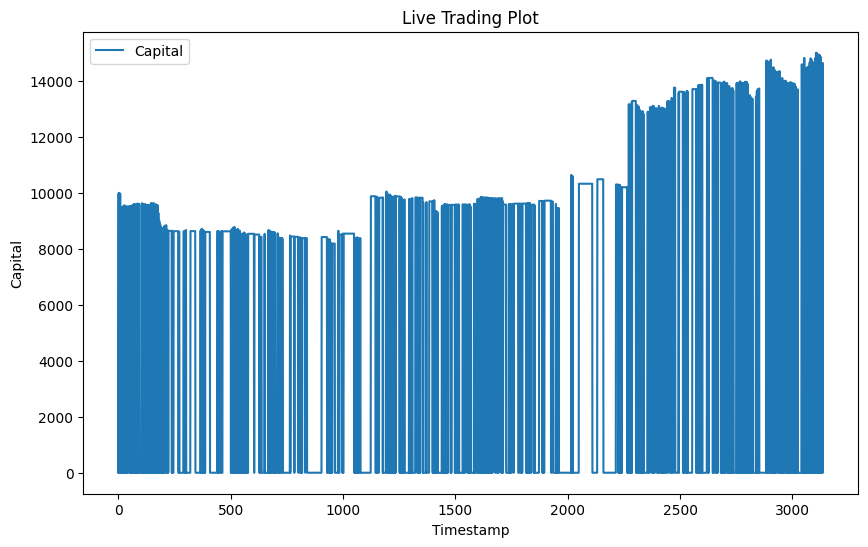

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')


class TechnicalIndicators:
    # Exponential Moving Average
    @staticmethod
    def ema(df, column, n):
        return pd.Series(df[column].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')

    # Rate of Change
    @staticmethod
    def roc(df, column, n):
        m = df[column].diff(n - 1)
        n = df[column].shift(n - 1)
        return pd.Series(((m / n) * 100), name=f'ROC_{n}')

    # Momentum
    @staticmethod
    def mom(df, column, n):
        return pd.Series(df[column].diff(n), name=f'Momentum_{n}')

    # Relative Strength Index
    @staticmethod
    def rsi(series, period):
        delta = series.diff().dropna()
        u = delta * 0
        d = u.copy()
        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]
        u[u.index[period - 1]] = np.mean(u[:period])
        u = u.drop(u.index[:(period - 1)])
        d[d.index[period - 1]] = np.mean(d[:period])
        d = d.drop(d.index[:(period - 1)])
        rs = u.ewm(com=period - 1, adjust=False).mean() / d.ewm(com=period - 1, adjust=False).mean()
        return 100 - 100 / (1 + rs)

    # Stochastic Oscillator %K
    @staticmethod
    def stok(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        return stok

    # Stochastic Oscillator %D
    @staticmethod
    def stod(close, low, high, n):
        stok = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
        stod = stok.rolling(3).mean()
        return stod

    # Moving Average
    @staticmethod
    def ma(df, n):
        ma = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name=f'ma_{n}')
        return ma


class LivePlot:
    def __init__(self, trade_history):
        self.trade_history = trade_history
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.set_title('Live Trading Plot')
        self.ax.set_xlabel('Timestamp')
        self.ax.set_ylabel('Capital')
        self.lines, = self.ax.plot([], [], label='Capital')
        self.ax.legend()
        self.update_plot()

    def update_plot(self):
        self.lines.set_xdata(range(len(self.trade_history)))
        self.lines.set_ydata(self.trade_history['capital'])
        self.ax.relim()
        self.ax.autoscale_view()
        display(self.fig)
        clear_output(wait=True)


class TradingStrategy:
    @staticmethod
    def implement(model, X, historical_data):
        signals = model.predict(X)

        position = 0
        wallet = 10000
        position_size = 1
        stop_loss_percent = 0.02
        take_profit_percent = 0.3
        buy_again_percent = 0.02
        buy_again =0
        quantity =0
        portfolio=0
        actual = wallet+portfolio

        trade_history = pd.DataFrame(columns=['timestamp', 'signal', 'price', 'quantity', 'capital','portfolio','actual', 'open', 'close',
                                              'high', 'low'])
        live_plot = LivePlot(trade_history)
        look_back=0
        for i in range(len(signals)):
            entry_price = historical_data['close'].iloc[i]

            if signals[i] == 1 and position == 0 :  # Buy signal and no current position
                entry_price = historical_data['close'].iloc[i]
                quantity = wallet*position_size/entry_price
                portfolio = quantity* entry_price
                look_back=portfolio
                wallet -= wallet * position_size
                actual = wallet+portfolio
                position = 1
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '1',
                                                      'price': entry_price,
                                                      'quantity': quantity,
                                                      'capital': wallet,
                                                      'portfolio':portfolio,
                                                      'actual':actual,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)

            elif signals[i] == 1 and position == 1:  # Sell signal and no current position
                entry_price = historical_data['close'].iloc[i]
                if entry_price >= look_back*(1+take_profit_percent):

                    wallet += quantity*entry_price
                    portfolio =0
                    quantity =0
                    look_back =0
                    actual = wallet+portfolio
                # wallet += wallet * position_size
                    position = 0
                    trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                          'signal': '-1',
                                                          'price': entry_price,
                                                          'quantity': 0,
                                                          'capital': wallet,
                                                          'portfolio':0,
                                                          'actual': actual,
                                                          'open': historical_data['open'].iloc[i],
                                                          'close': historical_data['close'].iloc[i],
                                                          'high': historical_data['high'].iloc[i],
                                                          'low': historical_data['low'].iloc[i]},
                                                        ignore_index=True)
                else:

                  trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                          'signal': '0',
                                                          'price': entry_price,
                                                          'quantity': quantity,
                                                          'capital': wallet,
                                                          'portfolio':portfolio,
                                                          'actual':actual,
                                                          'open': historical_data['open'].iloc[i],
                                                          'close': historical_data['close'].iloc[i],
                                                          'high': historical_data['high'].iloc[i],
                                                          'low': historical_data['low'].iloc[i]},
                                                        ignore_index=True)


            elif signals[i] == 0 and position == 0:  # Sell signal and no current position
                entry_price = historical_data['close'].iloc[i]

                # wallet += wallet * position_size
                position = 0
                trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                      'signal': '0',
                                                      'price': entry_price,
                                                      'quantity': 0,
                                                      'capital': wallet,
                                                      'portfolio':0,
                                                      'actual':actual,
                                                      'open': historical_data['open'].iloc[i],
                                                      'close': historical_data['close'].iloc[i],
                                                      'high': historical_data['high'].iloc[i],
                                                      'low': historical_data['low'].iloc[i]},
                                                     ignore_index=True)
            elif signals[i] == 0 and position == 1:  # sell signal and there is an open position

                    if look_back*(1-stop_loss_percent) >= entry_price :
                        wallet += quantity * entry_price
                        position = 0
                        portfolio =0
                        actual = wallet+portfolio
                        trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '-1',
                                                              'price': entry_price,
                                                              'quantity': 0,
                                                              'capital': wallet,
                                                              'portfolio':0,
                                                              'actual': actual,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)
                    else:
                       trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[i],
                                                              'signal': '0',
                                                              'price': entry_price,
                                                              'quantity': quantity,
                                                              'capital': wallet,
                                                              'portfolio':portfolio,
                                                              'actual':actual,
                                                              'open': historical_data['open'].iloc[i],
                                                              'close': historical_data['close'].iloc[i],
                                                              'high': historical_data['high'].iloc[i],
                                                              'low': historical_data['low'].iloc[i]},
                                                             ignore_index=True)

        if position != 0:
            current_price = historical_data['close'].iloc[-1]
            wallet += quantity * current_price
            portfolio=0
            actual = wallet+portfolio
            trade_history = trade_history.append({'timestamp': historical_data['timestamp'].iloc[-1],
                                                  'signal': '-1' if position == 1 else '0',
                                                  'price': current_price,
                                                  'quantity': position_size,
                                                  'capital': wallet,
                                                  'portfolio':portfolio,
                                                  'actual':actual,
                                                  'open': historical_data['open'].iloc[-1],
                                                  'close': historical_data['close'].iloc[-1],
                                                  'high': historical_data['high'].iloc[-1],
                                                  'low': historical_data['low'].iloc[-1]},
                                                 ignore_index=True)


        live_plot.trade_history = trade_history
        live_plot.update_plot()
        return trade_history


def create_technical_indicators(dataset):
    tech_indicators = TechnicalIndicators()

    dataset['MOM10'] = tech_indicators.mom(dataset, 'close', 10)
    dataset['MOM30'] = tech_indicators.mom(dataset, 'close', 30)
    dataset['ROC10'] = tech_indicators.roc(dataset, 'close', 10)
    dataset['ROC30'] = tech_indicators.roc(dataset, 'close', 30)
    dataset['EMA10'] = tech_indicators.ema(dataset, 'close', 10)
    dataset['EMA30'] = tech_indicators.ema(dataset, 'close', 30)
    dataset['EMA200'] = tech_indicators.ema(dataset, 'close', 200)
    dataset['RSI10'] = tech_indicators.rsi(dataset['close'], 10)
    dataset['RSI30'] = tech_indicators.rsi(dataset['close'], 30)
    dataset['RSI200'] = tech_indicators.rsi(dataset['close'], 200)
    dataset['%K10'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%D10'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 10)
    dataset['%K30'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%D30'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 30)
    dataset['%K200'] = tech_indicators.stok(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['%D200'] = tech_indicators.stod(dataset['close'], dataset['low'], dataset['high'], 200)
    dataset['MA21'] = tech_indicators.ma(dataset, 10)
    dataset['MA63'] = tech_indicators.ma(dataset, 30)
    dataset['MA252'] = tech_indicators.ma(dataset, 200)

    return dataset


def create_target_variable(df, look_forward_period=1):
    df['target'] = df['close'].shift(-look_forward_period) >= df['close']
    df['target'] = df['target'].astype(int)


def build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid):
    etc_model = ExtraTreesClassifier(random_state=42)

    grid = GridSearchCV(estimator=etc_model, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_result = grid.fit(X_train, y_train)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    ranks = grid_result.cv_results_['rank_test_score']
    for mean, stdev, param, rank in zip(means, stds, params, ranks):
        print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

    best_params = grid_result.best_params_
    etc_model.set_params(**best_params)
    etc_model.fit(X_train, y_train)

    predictions = etc_model.predict(X_test)

    print("\nFinal Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

    return etc_model


# Load data from CSV file
df = pd.read_csv('/content/Final_dataset_2_1.csv')
df.rename(columns={'Date': 'timestamp', 'Open': 'open', 'Close': 'close', 'High': 'high',
                   'Low': 'low'}, inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)





# Create technical indicators
df = create_technical_indicators(df)

# Create target variable
create_target_variable(df)

# Drop rows with NaN values resulting from creating technical indicators
df = df.dropna()

# Features and target variable
X_train = df.iloc[:int(0.7 * len(df))].drop(['timestamp', 'target'], axis=1)
y_train = df.iloc[:int(0.7 * len(df))]['target']

X_test = df.iloc[int(0.7 * len(df)):].drop(['timestamp', 'target'], axis=1)
y_test = df.iloc[int(0.7 * len(df)):]['target']

df_test = df.iloc[int(0.7 * len(df)):]

# Fine-tune parameters with Grid Search
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'criterion': ['gini', 'entropy']
}

# Build and evaluate the model
model = build_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid)

# Implement trading strategy
trade_history = TradingStrategy.implement(model, X_test, df_test)

# Print trade history
print("\nTrade History:")
print(trade_history)

# Save trade history to CSV
trade_history.to_csv('/content/trade_history.csv', index=False)


total_closed_trades = len(trade_history[trade_history['signal'] == '-1'])

winning_trades = trade_history[trade_history['signal'] == '1']
losing_trades = trade_history[trade_history['signal'] == '-1']
net_1 = winning_trades['actual']
net_2 = losing_trades['actual']
net_trade_value = []
mtr =0
mmtr=0
max_drawdown1=0

for i in range(len(net_1)):
    j = net_2.iloc[i] - net_1.iloc[i]
    net_trade_value.append(j)
    if j< 0:
      if max_drawdown1>j:
        mtr = winning_trades['actual'].iloc[i]
        mmtr = losing_trades['actual'].iloc[i]
        max_drawdown1 = j


gross_profit1=[]
gross_loss1=[]
# max_drawdown1=0
count=0
for val in net_trade_value:
  if val > 0:
    gross_profit1.append(val)
    count+=1
  else:
    gross_loss1.append(val)
    # max_drawdown1=min(max_drawdown1,

gross_profit_val = np.sum(gross_profit1)
gross_loss_val = np.sum(gross_loss1)


gross_profit = gross_profit_val
gross_loss = gross_loss_val
net_profit = gross_profit + gross_loss
max_drawdown = max_drawdown1
total_closed_trades = len(losing_trades)
win_rate = ( count / total_closed_trades) * 100
max_drowdown_percentage= (mtr-mmtr)/mtr *100
average_annual_returns = ((net_profit)/10000)*100

print("Requested Metrics for Model:")
print("1. Gross Profit: ${:,.2f}".format(gross_profit))
print("2. Net Profit: ${:,.2f}".format(net_profit))
print("3. Total Closed Trades: {}".format(total_closed_trades))
print("4. Win Rate (Profitability %): {:.2f}%".format(win_rate))
print("5. Max Drawdown: ${:,.2f}".format(max_drawdown))
print("6. Gross Loss: ${:,.2f}".format(gross_loss))
print("7. Max Drawdown Percentage: {:,.2f}".format(max_drowdown_percentage))
print("8. Average Annual Returns: {:,.2f}".format(average_annual_returns))

In [ ]:
print(net_trade_value)

[9981.538726658411, 9998.23039152085, 9978.285763653506, 9967.3764436376, 9488.217458972953, 9513.315673095896, 9542.905477434739, 9535.605979446991, 9540.334748750744, 9523.420864254727, 9497.47786746261, 9476.10284168757, 9510.64557643552, 9505.399782555787, 9509.552319588372, 9516.663376338061, 9511.125136126297, 9514.104038893522, 9520.011136759076, 9519.822882464163, 9559.39158219329, 9593.553611194598, 9579.409189628645, 9597.550071560789, 9603.414110583026, 9613.677899897988, 9584.879455688066, 9583.000284106136, 9594.816782782755, 9627.233541670092, 9579.859049193192, 9604.014236631927, 9593.889493814939, 9595.511592804478, 9578.815879066438, 9569.469481506896, 9554.439663913603, 9559.459034094894, 9542.77633963323, 9512.472048758218, 9533.773075971727, 9554.345584902236, 9555.767509995036, 9551.138989836503, 9581.874065415346, 9589.77209019273, 9632.683246267461, 9607.249151747255, 9600.944563247296, 9600.862173294498, 9595.751178467628, 9641.122944487124, 9550.190484461635, 9